# Jax functions

In [1]:
from tfpLigth import*
import os
import re
import jax
device = 'cpu'
if device == 'cpu':
    platform = os.getenv("JAX_PLATFORM_NAME", "cpu")
    jax.config.update("jax_platform_name", platform)
    Ncores = os.cpu_count()    
    xla_flags = os.getenv("XLA_FLAGS", "")
    xla_flags = re.sub(r"--xla_force_host_platform_device_count=\S+", "", xla_flags).split()
    os.environ["XLA_FLAGS"] = " ".join(["--xla_force_host_platform_device_count={}".format(Ncores)] + xla_flags)
    jax.config.update("jax_platform_name", platform)
    print('jax.local_device_count ',jax.local_device_count(backend=None))
elif device == 'gpu':
    platform = os.getenv("JAX_PLATFORM_NAME", "gpu")
    jax.config.update("jax_platform_name", platform)
elif device == 'tpu':
    platform = os.getenv("JAX_PLATFORM_NAME", "tpu")
    jax.config.update("jax_platform_name", platform)
else:
    print("platform not handled")
jax.local_device_count(backend=None)



jax.local_device_count  16


16

In [2]:
import random as r
from jax import jit
from functools import partial
init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
init_key = jnp.array(init_key)


@partial(jit, static_argnums=(1, 2,))
def vec_to_mat(arr, N, K):
    return jnp.reshape(arr, (N, K))

@jit
def jax_LinearOperatorDiag(s, cov):    
    def multiply_with_s(a):
        return jnp.multiply(a, s)
    vectorized_multiply = vmap(multiply_with_s)
    return jnp.transpose(vectorized_multiply(cov))
import jax.numpy as jnp

@jit
def diag_pre_multiply(v, m):
    return jnp.matmul(jnp.diag(v), m)
@jit
def random_centered(sigma, cor_mat, offset_mat):
    """Generate the centered matrix of random factors 

    Args:
        sigma (vector): Prior, vector of length N
        cor_mat (2D array): correlation matrix, cholesky_factor_corr of dim N, N
        offset_mat (2D array): matrix of offsets, matrix of dim N*k

    Returns:
        _type_: 2D array
    """
    return jnp.dot(diag_pre_multiply(sigma, cor_mat), offset_mat)

softmax_fn = vmap(jax.nn.softmax, in_axes=(0,))


# Set tensorflow probability function in global environment

In [3]:
#import tensorflow_probability.substrates.jax.distributions as tfd
## Get all names defined in the jnp
#all_names = dir(tfd)
## Create a dictionary with all names
#class_dict = {name: getattr(tfd, name) for name in all_names}
#
## Function to create new functions
#def create_new_function(class_obj):
#    def new_function(sample_shape=(), *args, **kwargs):
#        return tfd.Sample(class_obj(*args, **kwargs), sample_shape)
#    return new_function
#
## Create a Python file and write the functions to it
#with open("generated_functions.py", "w") as file:
#    for key, value in class_dict.items():
#        if callable(value):
#            try:
#                # Create the new function using the class object from class_dict
#                func_name = key.lower()
#                function_str = f"def {func_name}(sample_shape=(), *args, **kwargs):\n"
#                function_str += f"    return root(tfd.Sample({value.__name__}(*args, **kwargs), sample_shape))\n"
#                file.write(function_str)
#            except Exception as e:
#                print(f"Error creating function for {key}: {e}")
#        else:
#            print(f"Ignoring non-callable object for key {key}: {value}")
#
## Now all functions have been written to "generated_functions.py"


# Data manipulation

In [4]:
import numpy as np
def index(df, cols = 'all'):
    index_map = {}
    if cols == 'all':
        colCat = list(df.select_dtypes(['object']).columns)    
        for a in range(len(colCat)):                
            df["index_"+ colCat[a]] =  df.loc[:,colCat[a]].astype("category").cat.codes
            df["index_"+ colCat[a]] = df["index_"+ colCat[a]].astype(np.int64)
            index_map[colCat[a]] = dict(enumerate(df[colCat[a]].astype("category").cat.categories ) )
    else:
        if isinstance(cols, list) == False:
            cols = [cols]
        for a in range(len(cols)):
            df["index_"+ cols[a]] =  df.loc[:,cols[a]].astype("category").cat.codes
            df["index_"+ cols[a]] = df["index_"+ cols[a]].astype(np.int64)
            index_map[cols[a]] = dict(enumerate(df[cols[a]].astype("category").cat.categories ) )
    df.columns = df.columns.str.replace('.', '_')
    df.columns = df.columns.str.replace(' ', '_')
    
    return df


# Util functions

In [5]:
import re
import inspect
def tfp_trace_to_arviz(posterior, 
                       sample_stats,
                       var_names=None, 
                       sample_stats_name=['target_log_prob','log_accept_ratio','has_divergence','energy']):
    sample_stats = {k:jnp.transpose(v) for k, v in zip(sample_stats_name, sample_stats)}
    trace = {}
    for name, samp in zip(var_names, posterior):
        if len(samp.shape) == 2:
            transposed_shape = [1, 0]
        elif len(samp.shape) == 3:
            transposed_shape = [1, 0, 2]
        else:
            transposed_shape = [1, 0, 2, 3]
        trace[name] = jnp.transpose(samp, transposed_shape)
    trace = az.from_dict(posterior=trace, sample_stats=sample_stats)
    return trace



def get_distributions(model):
    source_code = inspect.getsource(model)
    lines = source_code.split('\n')

    variables = {}

    for line in lines:
        if not line or line.startswith('def') or 'independent' in line.lower() or not 'yield' in line:
            continue

        # Split the line into key and value
        key, value = line.split('=', 1)

        # Remove leading and trailing whitespace
        key = key.strip()

        # Find all words before the brackets
        words = re.findall(r'\b\w+\b(?=\()', value)

        # Create a dictionary with 'distribution' as the key and words as the value
        distribution = {
            'distribution': words[0]
        }

        # Add the key-value pair to the dictionary
        variables[key] = distribution

    return variables

def initialise(infos, init_params):
    init_params2 = []
    bijectors = []
    i = 0
    for key in infos.keys():  
        tmp = infos[key]['distribution'].lower()
        if 'lkj' in tmp:
            infos[key]['shape'] = int(init_params[i].shape[0])
            init_params2.append(jnp.array(jnp.eye(infos[key]['shape'])))            
            bijectors.append(tfp.bijectors.CorrelationCholesky())
        elif 'exponential' in tmp:
             init_params2.append(jnp.array(jnp.ones_like(init_params[i])))
             infos[key]['shape'] = init_params[i].shape
             bijectors.append(tfp.bijectors.Exp())
        else:
            init_params2.append(jnp.array(jnp.ones_like(init_params[i])))
            infos[key]['shape'] = init_params[i].shape
            bijectors.append(tfp.bijectors.Identity())
        i+=1
    return init_params2, bijectors

# MCMC function
## NUTS alone

In [6]:
import time as tm

def NUTS(model,  obs,  n_chains = 1, init = None,
         num_results = 500,
         num_burnin_steps=500,
         num_steps_between_results=0,
         parallel_iterations = 10,
         previous_kernel_results=None,
         return_final_kernel_results=False,
         seed=0,
         name=None):

    init_key, key = random.split(random.PRNGKey(int(seed)))
    init_key = jnp.array(init_key)

    tensor = JointDistributionCoroutine(model)
    infos = get_distributions(model)
    init_params = tensor.sample(seed = init_key)
    
    if init is None:
        init_params =  list(init_params)[:-1]
    else:
        init_params, bijectors = init

    names = infos.keys()

    def trace_fn(_, pkr):
        return (
            pkr.target_log_prob,
            pkr.leapfrogs_taken,
            pkr.has_divergence,
            pkr.energy,
            pkr.log_accept_ratio
        )

    def target_log_prob(*params):
        return tensor.log_prob(params + (obs,))
    
    @jit
    def run_chain(key):
        kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
        return tfp.mcmc.sample_chain(num_results = num_results,
            current_state= init_params,
            kernel=kernel,
            trace_fn=trace_fn,
            num_burnin_steps=num_burnin_steps,
            num_steps_between_results=num_steps_between_results,
            parallel_iterations = parallel_iterations,
            seed=key)


    start = tm.time()  
    rng_keys = jax.random.split(random.PRNGKey(0), n_chains)
    posterior, sample_stats =  jax.pmap(run_chain)(rng_keys)
    end = tm.time()    
    print(f"HonnorMode took: {end - start:.4f} seconds")

    return posterior, sample_stats


## NUTS + transformed

In [7]:
import tensorflow_probability
def NUTSdual(model,  obs,  n_chains = 1, init = None,
         num_results = 500,
         num_burnin_steps=500,
         num_steps_between_results=0,
         parallel_iterations = 10,
         previous_kernel_results=None,
         return_final_kernel_results=False,
         seed=0,
         name=None):

    init_key, key = random.split(random.PRNGKey(int(seed)))
    init_key = jnp.array(init_key)

    tensor = JointDistributionCoroutine(model)
    infos = get_distributions(model)
    init_params = tensor.sample(seed = init_key)
    
    _, bijectors = initialise(infos, init_params)
    init_params = list(init_params)[:-1]

    names = infos.keys()

    def trace_fn(_, pkr):
        return (
            pkr.inner_results.target_log_prob,
            pkr.inner_results.leapfrogs_taken,
            pkr.inner_results.has_divergence,
            pkr.inner_results.energy,
            pkr.inner_results.log_accept_ratio
        )
    
    def target_log_prob(*params):
      return tensor.log_prob(params + (obs,))
    
    @jit
    def run_chain(key):
        inner_kernel = tfp.mcmc.NoUTurnSampler(
            target_log_prob,
            step_size= 1e-3
        )

        kernel = tensorflow_probability.substrates.jax.mcmc.TransformedTransitionKernel(
                inner_kernel=inner_kernel,
                bijector=bijectors
            )

        return tfp.mcmc.sample_chain(num_results = num_results,
                                     num_steps_between_results = num_steps_between_results,
                                     current_state= init_params,
                                     kernel=kernel,
                                     trace_fn=trace_fn,
                                     num_burnin_steps=num_burnin_steps,
                                     parallel_iterations = parallel_iterations,
                                     seed=key)
    
    start = tm.time()  
    rng_keys = jax.random.split(random.PRNGKey(0), n_chains)
    result =  jax.pmap(run_chain)(rng_keys)
    end = tm.time()    
    print(f"HonnorMode took: {end - start:.4f} seconds")
    posterior, sample_stats = result

    return posterior, sample_stats 

## NUTS + transformed + Dual

In [8]:
import tensorflow_probability
def NUTStrans(model,  obs,  n_chains = 1, init = None, target_log_prob_fn = None,
         num_results = 500,
         num_burnin_steps=500,
         num_steps_between_results=0,
         parallel_iterations = 10,
         seed=0,
         name=None):

    init_key, key = random.split(random.PRNGKey(int(seed)))
    init_key = jnp.array(init_key)

    tensor = JointDistributionCoroutine(model)
    infos = get_distributions(model)
    init_params = tensor.sample(seed = init_key)
    
    _, bijectors = initialise(infos, init_params)
    init_params = list(init_params)[:-1]

    names = infos.keys()
    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
        )
    
    if target_log_prob_fn == None:
        def target_log_prob(*params):
            return tensor.log_prob(params + (obs,))
    else:
        def target_log_prob(*params):
            return target_log_prob_fn(params + (obs,))
    @jit
    def run_chain(key):
        inner_kernel = tfp.mcmc.NoUTurnSampler(
            target_log_prob,
            step_size= 1e-3
        )

        kernel = tensorflow_probability.substrates.jax.mcmc.TransformedTransitionKernel(
                inner_kernel=inner_kernel,
                bijector=bijectors
        )
        
        hmc  = tfp.mcmc.DualAveragingStepSizeAdaptation(
            kernel,
            target_accept_prob=.8,
            num_adaptation_steps=int(0.8*500),
            step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
                  inner_results=pkr.inner_results._replace(step_size=new_step_size)
              ),
            step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
        )
        
        return tfp.mcmc.sample_chain(num_results = num_results,
                                     num_steps_between_results = num_steps_between_results,
                                     current_state= init_params,
                                     kernel=hmc,
                                     trace_fn=trace_fn,
                                     num_burnin_steps=num_burnin_steps,
                                     parallel_iterations = parallel_iterations,
                                     seed=key)
    
    Ndevices = jax.local_device_count(backend=None)
    if(n_chains > Ndevices):
        runs = jnp.ceil(n_chains/Ndevices)
        print(runs)
        result = []
        for run in range(int(runs)):
            rng_keys = jax.random.split(random.PRNGKey(0), Ndevices)
            result.append(jax.pmap(run_chain)(rng_keys))
 
        return result
    else:
        start = tm.time()  
        rng_keys = jax.random.split(random.PRNGKey(0), n_chains)
        result =  jax.pmap(run_chain)(rng_keys)
        end = tm.time()    
        print(f"HonnorMode took: {end - start:.4f} seconds")
        posterior, sample_stats = result

    return posterior, sample_stats 

# Rethinking tests

## 1. Continuous variable: Model (model 4.3)

In [9]:
d = pd.read_csv('D:\OneDrive\Travail\Max Planck\Projects\BI\data\Howell1.csv', sep=';')
d = d[d.age > 18]


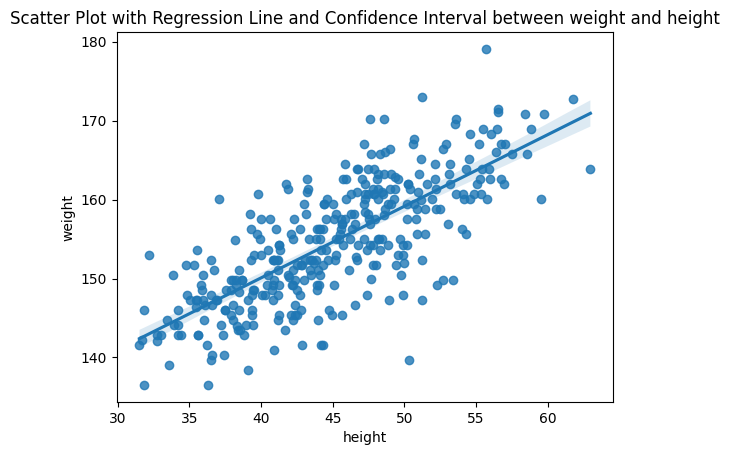

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot with regression line and confidence interval
sns.regplot(x=d.weight.values, y=d.height.values, data=df, ci=95)

# Set plot labels and title
plt.xlabel('height')
plt.ylabel('weight')
plt.title('Scatter Plot with Regression Line and Confidence Interval between weight and height')

plt.savefig('plot0.png')

In [77]:
## Model m4.3
d = pd.read_csv('/home/sosa/BI/data/Howell1.csv', sep=';')
d = d[d.age > 18]
#self.df["weight.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d.weight = d.weight - d.weight.mean()
d.age = d.age - d.age.mean()
weight = jnp.array(d.weight.values)
def model():
    s = yield uniform(1, 0, 50)
    a = yield normal(1, 178, 20)
    b = yield normal(1, 0, 1)    
    y = yield Independent(Normal(a+b*weight, s), reinterpreted_batch_ndims= 1)
    
posterior, sample_stats = NUTStrans(model, obs = jnp.array(d.height.values), n_chains = 4)

HonnorMode took: 1.1109 seconds


In [10]:
pd.DataFrame(
    {
        "BI": [jnp.mean(posterior[0], axis = 1)[0][0] , jnp.mean(posterior[1], axis = 1)[0][0] , jnp.mean(posterior[2], axis = 1)[0][0] ],
        "pystan": [5.144897,  154.649662, 0.904733]
    })

,BI,pystan
0,5.1593432,5.144897
1,154.62686,154.649662
2,0.9049445,0.904733


## 2. Categorical variable: Model (model 5.9)

In [127]:
#from src.main import*
d = pd.read_csv('/home/sosa/BI/data/milk.csv', sep=';')
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d = index(d, cols = "clade")
index_clade = jnp.array(d.index_clade.values, dtype=jnp.int32)
def model():
    s = yield exponential(1, 1)
    a = yield normal(4, 0, 0.5)  
    m = a[index_clade]
    y = yield tfd.Independent(tfd.Normal(m, s), reinterpreted_batch_ndims=1)
    
posterior, sample_stats = NUTSdual(model, obs = jnp.array(d.K.values))

HonnorMode took: 0.9042 seconds


In [49]:
pd.DataFrame(
    {
        "BI": jnp.concatenate([jnp.mean(posterior[0], axis = 1)[0] , jnp.mean(posterior[1], axis = 1)[0]]),
        "pystan": [0.801640, -0.459873,  0.353296, 0.636981, -0.547616]
    })

,BI,pystan
0,0.801499,0.801640
1,-0.443672,-0.459873
2,0.346701,0.353296
3,0.638811,0.636981
4,-0.568730,-0.547616


## 3. Continuous interactions terms (model 8.3)

In [128]:
d = pd.read_csv('/home/sosa/BI/data/tulips.csv', sep = ';')
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

water_cent = jnp.array(d.water_cent.values)
blooms_std = jnp.array(d.blooms_std.values)
shade_cent = jnp.array(d.shade_cent.values)

def model():
    sigma = yield exponential(1, 1)
    bws = yield normal(1,  0 , 0.25 )
    bs = yield normal(1,  0 , 0.25 )
    bw = yield normal(1,  0 , 0.25 )
    a = yield normal(1,  0.5 , 0.25 )
    mu = a + bw*water_cent + bs*shade_cent + bws*water_cent*shade_cent
    y = yield tfd.Independent(tfd.Normal(mu, sigma), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTSdual(model, obs = jnp.array(d.blooms_std.values))

HonnorMode took: 1.2564 seconds


In [51]:
pd.DataFrame(
    {
        "BI": jnp.concatenate([jnp.mean(posterior[0], axis = 1)[0], 
                jnp.mean(posterior[1], axis = 1)[0], 
                jnp.mean(posterior[2], axis = 1)[0], 
                jnp.mean(posterior[3], axis = 1)[0], 
                jnp.mean(posterior[4], axis = 1)[0]]),
        "pystan": [0.142327, -0.143176,  -0.112393, 0.206099,  0.358277]
    })

,BI,pystan
0,0.145584,0.142327
1,-0.139439,-0.143176
2,-0.112633,-0.112393
3,0.205490,0.206099
4,0.359399,0.358277


## 4. Binomial (model 11.1)

In [129]:
d = pd.read_csv('/home/sosa/BI/data/chimpanzees.csv', sep = ';')
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1
d_aggregated = (
    d.groupby(["treatment", "actor", "side", "cond"])["pulled_left"].sum().reset_index()
)
d_aggregated.rename(columns={"pulled_left": "left_pulls"}, inplace=True)
d_aggregated["actor_id"] = d_aggregated["actor"].values - 1

def model():
    a = yield normal(1,  0 , 10)
    y = yield Independent(Binomial(1, logits = a), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTSdual(model, obs = jnp.array(d.pulled_left.values), seed= 151)

HonnorMode took: 0.8969 seconds


In [54]:
pd.DataFrame(
    {
        "tfp": [jnp.mean(posterior[0])],
        "pystan": 0.321119
    })

,tfp,pystan
0,0.31404275,0.321119


##  5. Binomial with indices (model 11.4)

In [130]:
d = pd.read_csv('/home/sosa/BI/data/chimpanzees.csv', sep = ';')
d.actor = d.actor - 1
d["treatment"] = d.prosoc_left + 2 * d.condition
treatment = jnp.array(d["treatment"], dtype=jnp.int32)
actor = jnp.array(d["actor"] )
n_actor = len(jnp.unique(actor))
n_treatment= len(jnp.unique(treatment))

def model():
    a = yield normal(7, 0, 1.5)
    b = yield normal(4, 0, 0.5)
    p = a[actor] + b[treatment]
    y = yield Independent(Binomial(1, logits = p), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTSdual(model, obs = jnp.array(d.pulled_left.values), seed = 151)

HonnorMode took: 1.1508 seconds


In [56]:
pd.DataFrame(
    {
        "tfp": jnp.concatenate([jnp.mean(posterior[1], axis = 1)[0], jnp.mean(posterior[0], axis = 1)[0]]),
        "pystan": [0.-0.031648,
                   0.490967,
                   -0.375165,
                   0.376894,
                   -0.455304,
                   3.887521,
                   1.946828
                   -0.757069,
                   -0.758169,
                   -0.459580,
                   0.471230,
                   1.946828]
    })

,tfp,pystan
0,-0.036575,-0.031648
1,0.475207,0.490967
2,-0.384034,-0.375165
3,0.364707,0.376894
4,-0.442183,-0.455304
5,4.083852,3.887521
6,-0.740911,1.189759
7,-0.744570,-0.758169
8,-0.450640,-0.459580
9,0.478724,0.471230


## 6. Poisson (model 11.10)

In [131]:
d = pd.read_csv('/home/sosa/BI/data/Kline.csv', sep = ';')
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)
d['pLog'] = tf.math.log(d.P).numpy()
cid = jnp.array(d["cid"])
P = jnp.array(d["P"] )

def model():
    a = yield normal(2, 3,0.5)
    b = yield normal(2, 0,0.2)
    l = a[cid] + b[cid]*P
    y = yield Independent(Poisson(log_rate = l), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTSdual(model, obs = jnp.array(d.total_tools.values))

/home/sosa/.local/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/

HonnorMode took: 0.9352 seconds


In [58]:
pd.DataFrame(
    {
        "tfp": jnp.concatenate([jnp.mean(posterior[1], axis = 1)[0], jnp.mean(posterior[0], axis = 1)[0]]),
        "pystan": [0.377975, 0.190583, 3.319431, 3.610163]
    })

,tfp,pystan
0,0.375671,0.377975
1,0.181432,0.190583
2,3.326719,3.319431
3,3.608030,3.610163


## 7. Negative binomial (model 11.12) (PB estimation)

In [132]:
num_days = 30
y = tfd.Poisson(rate=1.5).sample(seed = init_key, sample_shape=(num_days,))
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample(seed = init_key, sample_shape=(num_weeks,))
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = d.days.pipe(np.log)

/home/sosa/.local/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/

In [133]:
num_days = 30
y = tfd.Poisson(rate=1.5).sample(seed = init_key, sample_shape=(num_days,))
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample(seed = init_key, sample_shape=(num_weeks,))
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = d.days.pipe(np.log)
log_days = jnp.array(d["log_days"].values)
monastery  = jnp.array(d.monastery.values)

/home/sosa/.local/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/

In [134]:
def model():
    a = yield normal(1, 0, 1)
    b = yield normal(1, 0, 1)
    l = jnp.exp(log_days + a +  b * monastery)
    y = yield Independent(Poisson(log_rate = l), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTSdual(model, obs = jnp.array(d.y.values))

/home/sosa/.local/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/

HonnorMode took: 0.9363 seconds


In [68]:
pd.DataFrame(
    {
        "tfp": jnp.concatenate([jnp.mean(posterior[0], axis = 1)[0], jnp.mean(posterior[1], axis = 1)[0]]),
        "pystan": [-0.866921, 1.210285]
    })

,tfp,pystan
0,-0.772670,-0.866921
1,1.505091,1.210285


## 8. Multinomial (model 11.13) (PB)

In [135]:
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income

# next line converts scores to probabilities
p = jnp.array(tf.nn.softmax(score))

# now simulate choice
# outcome career holds event type values, not counts
career = tfd.Categorical(probs=p).sample(seed = init_key, sample_shape = N)
result = [income[index] for index in career]
data = {'career': career, 'income': result}
d = pd.DataFrame(data)
career = jnp.array(d.career.values)
career_income = jnp.array(d.income.values)
income = jnp.array(income)

In [136]:
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income

# next line converts scores to probabilities
p = jnp.array(tf.nn.softmax(score))

# now simulate choice
# outcome career holds event type values, not counts
career = tfd.Categorical(probs=p).sample(seed = init_key, sample_shape = N)
result = [income[index] for index in career]
data = {'career': career, 'income': result}
d = pd.DataFrame(data)
career = jnp.array(d.career.values)
career_income = jnp.array(d.income.values)
income = jnp.array(income)


In [137]:
def model():
    a = yield normal(2, 0, 1)
    b = yield halfnormal(1,0.5)
    s_1 = a[0] + b * income[0]
    s_2 = a[1] + b * income[1]
    s_3 = [0]
    p = nn.softmax(jnp.stack([s_1[0], s_2[0], s_3[0]]))
    print(p.shape)
    p = p[career] 
    print(p.shape)
    y = yield Independent(Categorical(probs =  p))

posterior, sample_stats = NUTS(model, obs = career)

(3,)
(500,)
(3,)
(500,)
(3,)
(500,)


TypeError: sub got incompatible shapes for broadcasting: (500,), (2,).

In [53]:
init_key, key = random.split(random.PRNGKey(int(51651)))
init_key = jnp.array(init_key)
tensor = JointDistributionCoroutine(model)
infos = get_distributions(model)
init_params = tensor.sample(seed = init_key)
init_params =  list(init_params)[:-1]
init_params
init_params.append(jnp.array(d.career.values))

In [ ]:
def model():
    a = yield normal(2, 0, 1)
    b = yield HalfNormal(1, 0.5)
    p = softmax_fn(a[career_income] + b[career_income])
    print(p.shape)
    y = yield tfd.Independent(Multinomial(1, probs = p))
    
posterior, sample_stats = NUTS(model, obs = jnp.array(d.career.values))

## 9. Beta binomial (model m12.1)

In [138]:
d = pd.read_csv('/home/sosa/BI/data/UCBadmit.csv', sep = ';')
d["gid"] = (d["applicant.gender"] != "male").astype(int)
gid = jnp.array(d["gid"].astype('int32').values)
applications = jnp.array(d["applications"].astype('float32').values)
admit = jnp.array(d["admit"].astype('float32').values)

def model():
    phi = yield exponential(1, 1)
    #phi2 =  tfp.bijectors.Exp().forward(phi)
    alpha = yield normal(2,0.,1.5)
    theta = phi + 2
    pbar = nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    y = yield Independent(BetaBinomial(applications, concentration1 = concentration1, concentration0 = concentration0), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTSdual(model, obs = admit)

HonnorMode took: 1.3988 seconds


In [60]:
posterior2, sample_stats = NUTS(model, obs = admit)

HonnorMode took: 2.6830 seconds


In [74]:
pd.DataFrame(
    {
        "BI NUTSdual": jnp.concatenate([jnp.mean(posterior[0], axis = 1)[0], jnp.mean(posterior[1], axis = 1)[0]]),
        "BI NUTS": jnp.concatenate([jnp.mean(posterior2[0], axis = 1)[0], jnp.mean(posterior2[1], axis = 1)[0]]),
        "pystan": [1.014828, -0.440553, -0.320719]
    })

,BI NUTSdual,BI NUTS,pystan
0,0.923973,0.523416,1.014828
1,-0.439733,-0.411268,-0.440553
2,-0.344476,-0.314011,-0.320719


## 10. Negative-binomial

In [142]:
d = pd.read_csv('/home/sosa/BI/data/UCBadmit.csv', sep = ';')
d["gid"] = (d["applicant.gender"] != "male").astype(int)
gid = jnp.array(d["gid"].astype('int32').values)
applications = jnp.array(d["applications"].astype('float32').values)
admit = jnp.array(d["admit"].astype('float32').values)

def model():
    phi = yield exponential(1, 1)
    alpha = yield normal(2,0.,1.5)
    theta = phi + 2
    pbar = nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    y = yield Independent(BetaBinomial(applications, concentration1 = concentration1, concentration0 = concentration0), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTS(model, obs = admit)

HonnorMode took: 2.6745 seconds


## 11. Zero inflated outcomes (PB estimations)

In [ ]:
r.seed(42)
# Define parameters
prob_drink = 0.2  # 20% of days
rate_work = 1     # average 1 manuscript per day

# sample one year of production
N = 365

np.random.seed(365)
drink = np.random.binomial(1, prob_drink, N)
y = (1 - drink) * np.random.poisson(rate_work, N)
d = pd.DataFrame(y)

def model():
    al = yield normal(1, 1, 0.5)
    ap = yield normal(1, -1.5 , 1)
    y = yield Independent(ZeroInflatedNegativeBinomial(total_count = 365, inflated_loc_logits = al, logits = jnp.log(ap)), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTSdual(model, obs = jnp.array(d.iloc[:,0].values))


In [76]:
pd.DataFrame(
    {
        "BI NUTS": jnp.concatenate([jnp.mean(posterior[0], axis = 1)[0], jnp.mean(posterior[1], axis = 1)[0]]),
        "pystan": [-1.370638, 0.104704]
    })

,BI NUTS,pystan
0,0.613457,-1.370638
1,0.004344,0.104704


## 12. Varying interceps

In [143]:
d = pd.read_csv('/home/sosa/BI/data/reedfrogs.csv', sep = ';')
d["tank"] = np.arange(d.shape[0])
tank = jnp.array(d["tank"].astype('int32').values)
density = jnp.array(d["density"].astype('float32').values)
def model():
    sigma = yield exponential(1, 1)
    a_bar = yield normal(1, 0, 1.5)
    alpha = yield normal(48, a_bar, sigma)
    p = jnp.squeeze(alpha[tank])[0]
    y = yield Independent(Binomial(total_count = density, logits = p), reinterpreted_batch_ndims=1)

posterior, sample_stats = NUTS(model, obs = jnp.array(d.surv.astype('float32').values))

HonnorMode took: 1.9781 seconds


In [124]:
pd.DataFrame(
    {
        "BI NUTSdual": jnp.concatenate([jnp.mean(posterior[0], axis = 1)[0], jnp.mean(posterior[1], axis = 1)[0], jnp.mean(posterior[2], axis = 1)[0][0]]),
        "pystan": [1.621539,
                    1.345123,
                    2.140623,
                    3.075581,
                    0.997040,
                    3.067604,
                    2.138858,
                    2.146644,
                    3.069126,
                    2.131292,
                    -0.177990,
                    2.145196,
                    0.999936,
                    0.578882,
                    1.009545,
                    0.184045,
                    2.152843,
                    2.130130,
                    2.909044,
                    2.404756,
                    2.015801,
                    3.670685,
                    2.392812,
                    2.403261,
                    2.403139,
                    1.702271,
                    -1.001493,
                    0.162632,
                    -1.439793,
                    -0.472672,
                    0.158220,
                    1.444945,
                    -0.630888,
                    -0.307811,
                    3.185393,
                    2.712255,
                    2.706410,
                    2.059125,
                    2.054994,
                    3.904811,
                    2.701189,
                    2.354839,
                    -1.814108,
                    -0.572653,
                    -0.450904,
                    -0.341859,
                    0.578379,
                    -0.580085,
                    2.066660,
                    0.001912]
    })

,BI NUTSdual,pystan
0,1.606676,1.621539
1,1.354982,1.345123
2,2.151212,2.140623
3,3.352207,3.075581
4,0.999321,0.997040
5,2.919931,3.067604
6,1.964355,2.138858
7,1.930002,2.146644
8,2.938609,3.069126
9,2.034379,2.131292


## 13. Varying effects 

In [1]:
import math
import os

import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Image, set_matplotlib_formats
from matplotlib.patches import Ellipse, transforms

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import expit

import numpy as onp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS, Predictive

az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = jnp.array([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])

sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)
N_cafes = 20
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = dist.MultivariateNormal(Mu, Sigma).sample(seed, (N_cafes,))
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]
seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = dist.Normal(mu, sigma).sample(seed)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
@jit
def random_centered(sigma, cor_mat, offset_mat):
    """Generate the centered matrix of random factors 

    Args:
        sigma (vector): Prior, vector of length N
        cor_mat (2D array): correlation matrix, cholesky_factor_corr of dim N, N
        offset_mat (2D array): matrix of offsets, matrix of dim N*k

    Returns:
        _type_: 2D array
    """
    return jnp.dot(diag_pre_multiply(sigma, cor_mat), offset_mat)


In [12]:
import time as tm
cafe_id = jnp.array(d.cafe.values)
def model():    
    sigma = yield exponential(1,1)
    a = yield normal(1, 5, 2)
    b = yield normal(1, -1, 0.5)
    sigma_cafe = yield exponential(2, 1)    
    Rho = yield lkj((), 2, 2)
    a_cafe_b_cafe = yield multivariatenormaltril(N_cafes, loc = jnp.stack([a, b], axis=1)[0], scale_tril =  Rho * sigma_cafe)
    mu = a_cafe_b_cafe[:, 0][cafe_id] + a_cafe_b_cafe[:, 1][cafe_id] * afternoon
    y = yield Independent(Normal(mu, sigma), reinterpreted_batch_ndims=[1])

posterior, sample_stats = NUTStrans(model, obs = jnp.array(d.wait.astype('float32').values))


c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

ValueError: Incompatible shapes for broadcasting: shapes=[(200, 2), (200,)]

In [192]:
df.sigma.mean()
df.a.mean()
df.b.mean()
df['sigma_cafe.1'].mean()
df['sigma_cafe.2'].mean()
df['Rho.1.1'].mean()
df['Rho.2.1'].mean()
df['Rho.1.2'].mean()
df['Rho.2.2'].mean()
df['a_cafe.1'].mean()

1.2873298097592565

In [181]:
print(jnp.mean(posterior[0], axis = 1)[0])#sigma
print(jnp.mean(posterior[1], axis = 1)[0])#a
print(jnp.mean(posterior[2], axis = 1)[0])#b
print(jnp.mean(posterior[3], axis = 1)[0])#sigma_cafe
print(jnp.mean(posterior[4], axis = 1))#Rho
print(jnp.mean(posterior[5], axis = 1)[0])#a_cafe_b_cafe

[0.53117263]
[3.14133]
[-0.883886]
[1.0519485 0.3173299]
[[[ 1.          0.        ]
  [-0.41266596  0.9050291 ]]]
[[ 1.2774819  -0.03088792]
 [ 2.6031518  -0.647734  ]
 [ 2.572913   -0.37040803]
 [ 3.8227131  -0.98856807]
 [ 2.3991852  -0.7891954 ]
 [ 2.0080462  -0.50236875]
 [ 3.2757096  -0.87508285]
 [ 1.9705095  -0.40668753]
 [ 3.5029655  -1.110885  ]
 [ 2.7006576  -0.48040327]
 [ 5.4795637  -1.8634117 ]
 [ 3.0171678  -0.6829112 ]
 [ 3.6504285  -0.80163425]
 [ 4.10381    -1.3567264 ]
 [ 4.4678607  -1.3806102 ]
 [ 3.2447562  -1.2172555 ]
 [ 2.4375496  -1.0564926 ]
 [ 3.8227077  -1.2483317 ]
 [ 3.4980464  -1.0867492 ]
 [ 1.8433901  -0.3030343 ]]


In [178]:
import time as tm
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """ 
data{
    vector[200] wait;
    array[200] int afternoon;
    array[200] int cafe;
}
parameters{
    vector[20] b_cafe;
    vector[20] a_cafe;
    real a;
    real b;
    vector<lower=0>[2] sigma_cafe;
    real<lower=0> sigma;
    corr_matrix[2] Rho;
}
model{
    vector[200] mu;
    Rho ~ lkj_corr( 2 );
    sigma ~ exponential( 1 );
    sigma_cafe ~ exponential( 1 );
    b ~ normal( -1 , 0.5 );    
    a ~ normal( 5 , 2 );
    {
        array[20] vector[2] YY;
        vector[2] MU;
        MU = [ a , b ]';
        for ( j in 1:20 ) YY[j] = [ a_cafe[j] , b_cafe[j] ]';
        YY ~ multi_normal( MU , quad_form_diag(Rho , sigma_cafe) );
    }
    for ( i in 1:200 ) {
        mu[i] = a_cafe[cafe[i]] + b_cafe[cafe[i]] * afternoon[i];        
    }
    
    wait ~ normal( mu , sigma );

}
"""
data = {
    'wait' : d['wait'].values.astype(float),
    'afternoon' : d['afternoon'].values.astype(int),
    'cafe' : d['cafe'].values.astype(int)+1,
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=4, num_samples=2000, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 25.4s, done.Messages from stanc:
Warning in '/tmp/httpstan_yqkgg554/model_y5f2lzzr.stan', line 18, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Sampling:  25% (2500/10000)
Sampling:  50% (5000/10000)
Sampling:  75% (7500/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradien

Pystan took: 28.7846 seconds


In [115]:
pd.DataFrame(
    {
        "tfp": az.summary(trace,round_to='none')['mean'],
        "pystan": [df['a'].mean(),df['b'].mean(),
                   df['sigma_cafe.1'].mean(),
                   df['sigma_cafe.2'].mean(),   
                   df['sigma'].mean(),                
                   df['Rho.1.1'].mean(),df['Rho.2.1'].mean(),
                   df['Rho.1.2'].mean(),df['Rho.2.2'].mean(),                   
                   df['a_cafe.1'].mean(), df['b_cafe.1'].mean(),
                   df['a_cafe.2'].mean(), df['b_cafe.2'].mean(),
                   df['a_cafe.3'].mean(), df['b_cafe.3'].mean(),
                   df['a_cafe.4'].mean(), df['b_cafe.4'].mean(),
                   df['a_cafe.5'].mean(), df['b_cafe.5'].mean(),
                   df['a_cafe.6'].mean(), df['b_cafe.6'].mean(),
                   df['a_cafe.7'].mean(), df['b_cafe.7'].mean(),
                   df['a_cafe.8'].mean(), df['b_cafe.8'].mean(),
                   df['a_cafe.9'].mean(), df['b_cafe.9'].mean(),
                   df['a_cafe.10'].mean(), df['b_cafe.10'].mean(),
                   df['a_cafe.11'].mean(), df['b_cafe.11'].mean(),
                   df['a_cafe.12'].mean(), df['b_cafe.12'].mean(),
                   df['a_cafe.13'].mean(), df['b_cafe.13'].mean(),
                   df['a_cafe.14'].mean(), df['b_cafe.14'].mean(),
                   df['a_cafe.15'].mean(), df['b_cafe.15'].mean(),
                   df['a_cafe.16'].mean(), df['b_cafe.16'].mean(),
                   df['a_cafe.17'].mean(), df['b_cafe.17'].mean(),
                   df['a_cafe.18'].mean(), df['b_cafe.18'].mean(),
                   df['a_cafe.19'].mean(), df['b_cafe.19'].mean(),
                   df['a_cafe.20'].mean(), df['b_cafe.20'].mean(),
                   ]
    })

/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,tfp,pystan
alpha[0],3.681804,3.677735
beta[0],-1.038721,-1.043785
sigma_cafe[0],0.996543,1.004749
sigma_cafe[1],0.780823,0.635579
sigma[0],0.502117,0.498614
"rho[0, 0]",1.000000,1.000000
"rho[0, 1]",0.000000,-0.635529
"rho[1, 0]",0.020340,-0.635529
"rho[1, 1]",0.848365,1.000000
"a_cafe_b_cafe[0, 0]",3.058267,3.032632


# Data size

In [49]:
import seaborn as sns
import numpy as np
import jax
from jax import random
from jax.nn import softmax
import jax.numpy as jnp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

###############################################################################
############ SIMULATING MULTINOMIAL DATA WITH SOFTMAX LINK FUNCTION ###########
def mysoftmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=0)

K = 3
N = 100
N_obs = 2
sigma_random = 0.6


########################################################
################### Fixed effect Sim ###################
#a = np.random.normal(0, 1, K)
a = np.array([3,1,1]) # Forcing a values


# Factors--------------------------
NY = 4
NV = 8

Y2 = np.full((NV, NY), np.nan) 
means = np.random.normal(0, 1, NY)
offsets = np.random.normal(0, 1, NV)
for i in range(NV):
  for k in range(NY):
    Y2[i,k] = means[k] + offsets[i]

b_individual = np.random.normal(0, 1, (N, K))
mu = b_individual + a


# Declare an empty Matrix to fill with data
Y = np.empty((N * N_obs, K))

# Declare an empty vector to fill with IDs
id = []

# Loop over each individual
for i in range(N):
    # Simulate N_obs draws from the multinomial
    Y[i*N_obs:(i+1)*N_obs, :] = np.apply_along_axis(lambda x: np.random.multinomial(100, mysoftmax(x)), 0, mu[i])
    # Assign ID vector
    id += [i] * N_obs


N = N*N_obs
K = K
ni = N
y = jnp.array(Y, dtype=jnp.int32).reshape(N, K)
i_ID = jnp.array(id)

dat = dict(
    K = K,
    ni = ni,
    y = y,
    i_ID = i_ID
)
Y2 = jnp.array(Y2)

In [7]:
#init_key, key = random.split(random.PRNGKey(int(seed)))
#init_key = jnp.array(init_key)
#means = Normal(0, 1).sample(NY, seed = init_key)
#offset = Normal(0, 1).sample([NV,1], seed = init_key)
#sigma = Exponential(1).sample([NY], seed = init_key)  
#tmp = jnp.tile(means, [NV, 1]) # Correct
#mu_l =  tmp + offset
#mu_l
#jnp.tile(sigma, [NV, 1]) 

In [50]:
jax.devices()

[CpuDevice(id=0)]

In [46]:
n_chains = 1
def model():
    means = yield normal(NY, 0, 1)
    offset = yield normal([NV, 1], 0, 1)
    sigma = yield exponential(NY, 1)  
    tmp = jnp.tile(means, [NV, 1])
    mu_l =  tmp + offset
    y = yield Independent(Normal(mu_l, jnp.tile(sigma, [NV, 1]) ),  reinterpreted_batch_ndims=2)
posterior, sample_stats = NUTStrans(model, obs = Y2, n_chains = n_chains, num_results = 1000, num_burnin_steps = 1000)

HonnorMode took: 13.7202 seconds


In [42]:
len(result)

10

In [19]:
means

array([0.33272076, 0.5066617 , 0.10083277, 0.72349854])

In [18]:
jnp.mean(jnp.reshape(posterior[0], (n_chains*1000, 4)), axis = 0)

Array([0.4229656 , 0.59690624, 0.191077  , 0.8137438 ], dtype=float32)

In [20]:
jnp.std(jnp.reshape(posterior[0], (n_chains*1000, 4)), axis = 0)

Array([0.04535762, 0.04535593, 0.04535816, 0.04535832], dtype=float32)

In [21]:
offsets

array([ 0.215217  , -0.62375594,  0.72093496,  0.32128815,  0.88970604,
       -0.2219603 , -0.49029272, -0.39627718])

In [22]:
jnp.mean(jnp.reshape(posterior[1], (n_chains*1000, 8)), axis = 0)

Array([ 0.1249738 , -0.71400034,  0.6306909 ,  0.23104739,  0.7994598 ,
       -0.3122051 , -0.58053434, -0.4865218 ], dtype=float32)

In [23]:
jnp.std(jnp.reshape(posterior[1], (n_chains*1000, 8)), axis = 0)

Array([0.04535718, 0.04535824, 0.04535807, 0.04535695, 0.04535654,
       0.04535753, 0.04535542, 0.04535763], dtype=float32)

In [23]:
import time as tm
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
import numpy as np
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """ 
data {
  int nv;                     // NUmber of Unique Villages
  int NY;
  matrix[nv, NY] Y;               // Predictors of Market integration

}
parameters {
  vector[nv] offsets; // Market Integration offset.
  vector[NY] means;  // Means for predictors of Market Integration
  vector<lower = 0>[NY] sigmas; // Sigmas for Market Integration
}
model{
  matrix[nv, NY] mu_l;
  means ~ normal(0, 1);
  offsets ~ normal(0, 1);
  sigmas ~ exponential(1);
  
  for(k in 1:NY){
    for( i in 1:nv ){
      mu_l[i,k] = means[k] + offsets[i];
    }
    Y[,k] ~ normal( mu_l[,k] , sigmas[k]);
  }
}

"""
data = {
    'nv' :NV,
    'NY' : NY,
    'Y' : Y2
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=1000, num_warmup = 1000)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 14.0s, done.Sampling:   0%/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_iz2dztdy

Pystan took: 17.1906 seconds


# Multinomial model with random factors
## Data

In [16]:
from tfpLigth import*
import pandas as pd
d = pd.read_csv('jeff/small_dat.csv')
d = d.iloc[0:500, :]
d.shape
cats = d.iloc[:,1:62]
N = d.shape[0]
K = d.K.unique()[0]-1
ni = d.ni.unique()[0]-1
i_ID = jnp.array(d.i_ID.values)
y = jnp.array(cats)


#a = Normal(0, 1).sample(seed = init_key, sample_shape=K)
#L_individual = LKJ(int(ni), int(ni)).sample(seed = init_key, sample_shape=())
#Sigma_individual = Exponential(1).sample(seed = init_key, sample_shape=ni)
#z_individual = Normal(0, 1).sample(seed = init_key, sample_shape=(ni, K))
#b_individual = random_centered(Sigma_individual, L_individual, z_individual)
#random_effect = b_individual[i_ID]
#p = jnp.stack([a + random_effect])
#y = DirichletMultinomial(N, softmax_fn(p)).sample(seed = init_key)


## Model

In [ ]:
def model():
    a = yield normal(K, 0, 1)
    L_individual = yield lkj((), ni, concentration = 1.5) 
    Sigma_individual = yield exponential(ni, 1)
    z_individual = yield normal((ni, K), 0, 1)
    rf = random_centered(Sigma_individual, L_individual, z_individual)[i_ID]
    y = yield tfd.Independent(DirichletMultinomial (N, jnp.exp(a + rf)), reinterpreted_batch_ndims =  1)
    
tensor = JointDistributionCoroutineAutoBatched(model)
init_params = tensor.sample(seed = init_key)
tensor.log_prob(init_params)
y = jnp.array(cats.values)
#tensor.sample(seed = init_key)

In [20]:
posterior, sample_stats = NUTSdual(model, obs = y)

/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, minval=minval, maxval=maxv

HonnorMode took: 7.8645 seconds


In [23]:
jnp.mean(posterior[0], axis=1)

Array([[ 0.05615622, -0.6663588 ,  1.3982416 ,  0.62313735,  0.8350297 ,
         1.0651187 , -0.7151321 ,  1.7792015 ,  0.8875723 , -1.3659457 ,
         1.3132203 , -0.28332764, -0.62546504, -1.1582158 , -0.09721471,
         0.7409373 ,  1.19223   ,  1.0297832 , -0.8839252 , -0.03948881,
         1.0382149 , -0.8449937 , -0.4245596 , -0.49214274,  0.05853189,
        -0.59798425, -1.0161266 ,  0.02900102, -0.6771232 , -0.63163674,
         1.1186483 , -0.05101798, -0.86955243, -0.52079815,  0.23145588,
         0.6927144 , -0.14934132,  0.06697238, -0.8134827 , -0.37827206,
         0.05702852, -0.44461018,  0.8572168 ,  0.10744796, -0.36828473,
        -0.6958005 , -0.06352754,  0.60554266, -0.92917377, -0.86278415,
        -1.035126  ,  0.08371376, -0.10018361,  0.190146  ,  1.3295493 ,
        -0.13258067,  0.60345596,  1.1266363 ,  0.23537996,  1.2127706 ,
        -1.139107  ]], dtype=float32)

In [24]:
jnp.mean(posterior[2], axis=1)

Array([[1.39305568e+00, 4.00237083e-01, 9.16378573e-02, 9.61950302e-01,
        1.23204792e+00, 5.86139038e-02, 5.67673540e+00, 1.12955308e+00,
        1.39652896e+00, 7.06040442e-01, 6.80083394e-01, 4.96822521e-02,
        2.34810889e-01, 1.57803154e+00, 8.98694038e-01, 4.48252261e-01,
        5.60243070e-01, 1.31814384e+00, 1.27323282e+00, 5.02183914e-01,
        1.16391730e+00, 5.32268941e-01, 1.99821904e-01, 8.40371072e-01,
        5.34804344e-01, 8.28324378e-01, 2.20273569e-01, 4.65340525e-01,
        2.11460352e+00, 2.39558756e-01, 2.15173721e-01, 1.52623761e+00,
        7.44600371e-02, 1.06354833e+00, 1.02381873e+00, 8.56124878e-01,
        4.03137714e-01, 4.53552151e+00, 1.49732322e-01, 5.20960391e-01,
        1.44391584e+00, 7.37378359e-01, 4.18330789e-01, 1.50932145e+00,
        2.56037444e-01, 8.42307657e-02, 6.79948747e-01, 6.76697642e-02,
        6.20886266e-01, 1.25371933e+00, 2.13660502e+00, 1.45660892e-01,
        5.20948600e-03, 3.19303441e+00, 1.41794002e+00, 4.288074

## Initialized parameters

In [25]:
import tensorflow as tf
for a in init_params:
    print(a.shape)

init_params2 = []
init_params2.append(jnp.array(jnp.ones_like(init_params[0])))
init_params2.append(jnp.array(jnp.eye(ni)))
init_params2.append(jnp.array(jnp.ones_like(init_params[2])))
init_params2.append(jnp.array(jnp.ones_like(init_params[3])))

for a in init_params2:
    print(a.shape)

(61,)
(404, 404)
(404,)
(404, 61)
(500, 61)
(61,)
(404, 404)
(404,)
(404, 61)


## Bijectors

In [19]:
from tensorflow_probability.substrates import jax as tfp
bijectors = []
bijectors.append(tfp.bijectors.Identity())
bijectors.append(tfp.bijectors.CorrelationCholesky(ni))
bijectors.append(tfp.bijectors.Exp())
bijectors.append(tfp.bijectors.Identity())
bijectors

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.CorrelationCholesky 'correlation_cholesky' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=2 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]

In [ ]:
def pack_tril(x):
    n = x.shape[0]
    return x[jnp.tril_indices(n)]

dist = tfp.distributions.CholeskyLKJ(dimension=50, concentration= 1000)
bijector = dist.experimental_default_event_space_bijector()
s = dist.sample(seed = init_key)
bijector.forward(pack_tril(s))

## Samplers

#### DualAveragingStepSizeAdaptation

In [13]:
def trace_fn(_, pkr):
    return (
        pkr.inner_results.target_log_prob,
        pkr.inner_results.leapfrogs_taken,
        pkr.inner_results.has_divergence,
        pkr.inner_results.energy,
        pkr.inner_results.log_accept_ratio
    )

def target_log_prob(*params):
  return tensor.log_prob(params + (y,))

@jit
def run_chain(key):
    inner_kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob,
        step_size= 1e-3
    )
    #hmc  = tfp.mcmc.DualAveragingStepSizeAdaptation(
    #    inner_kernel,
    #    target_accept_prob=.8,
    #    num_adaptation_steps=int(0.8*500),
    #    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
    #        step_size=new_step_size
    #    ),
    #    step_size_getter_fn=lambda pkr: pkr.step_size,
    #    log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
    #)
    kernel = tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=inner_kernel,
            bijector=bijectors
        )
    #hmc  = tfp.mcmc.DualAveragingStepSizeAdaptation(
    #    inner_kernel,
    #    target_accept_prob=.8,
    #    num_adaptation_steps=int(0.8*500),
    #    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
    #        step_size=new_step_size
    #    ),
    #    step_size_getter_fn=lambda pkr: pkr.step_size,
    #    log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
    #)
    return tfp.mcmc.sample_chain(num_results = 500,
                                 num_steps_between_results = 0,
                                 current_state= init_params2,
                                 kernel=kernel,
                                 trace_fn=trace_fn,
                                 num_burnin_steps=500,
                                 parallel_iterations = 0,
                                 seed=key)

start = tm.time()  
rng_keys = jax.random.split(random.PRNGKey(0), 1)
result =  jax.pmap(run_chain)(rng_keys)
end = tm.time()    
print(f"HonnorMode took: {end - start:.4f} seconds")
posterior, sample_stats = result


In [ ]:
from functools import partial
import time as tm
import arviz as az
import tensorflow as tf

def trace_fn(_, pkr):
    return (
        pkr.target_log_prob,
        pkr.leapfrogs_taken,
        pkr.has_divergence,
        pkr.energy,
        pkr.log_accept_ratio
    )

def target_log_prob(*params):
  return tensor.log_prob(params + (y,))

@jit
def run_chain(key):
    inner_kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob,
        step_size= 1e-3
    )
    kernel = tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=inner_kernel,
            bijector=bijectors
        )
    hmc  = tfp.mcmc.DualAveragingStepSizeAdaptation(
        kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*500),
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
              inner_results=pkr.inner_results._replace(step_size=new_step_size)
          ),
        step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    )
    return tfp.mcmc.sample_chain(500,
        current_state= init_params2,
        kernel=hmc,
        trace_fn=trace_fn,
        num_burnin_steps=500,
        parallel_iterations = 10,
        seed=key)

In [12]:
start = tm.time()  
rng_keys = jax.random.split(random.PRNGKey(0), 1)
result =  jax.pmap(run_chain)(rng_keys)
end = tm.time()    
print(f"HonnorMode took: {end - start:.4f} seconds")
posterior, sample_stats = result

: 

In [14]:
get_distributions(model)

{'a': {'distribution': 'normal'},
 'L_individual': {'distribution': 'lkj'},
 'Sigma_individual': {'distribution': 'exponential'},
 'z_individual': {'distribution': 'normal'}}

In [22]:
jnp.mean(posterior[0], axis=1)

NameError: name 'posterior' is not defined

In [14]:
jnp.mean(posterior[2], axis=1)

Array([[ 1.00011063e+00,  1.52363613e-01, -8.19926485e-02,
         1.30560052e+00,  1.69159555e+00,  1.07562788e-01,
         5.61449814e+00,  7.25113809e-01,  1.38531935e+00,
         7.02273369e-01,  8.18800211e-01,  1.67456195e-01,
         1.40602008e-01,  2.05478144e+00,  1.09147692e+00,
         3.67792130e-01,  1.08147003e-01,  1.47573376e+00,
         1.19409811e+00,  7.80298471e-01,  7.04531312e-01,
         8.04857433e-01, -1.89564675e-02,  8.73912454e-01,
         8.11408460e-01,  7.46483505e-01,  3.87466133e-01,
         2.71474361e-01,  1.97974360e+00,  7.81769119e-03,
        -2.70633269e-02,  1.76259911e+00,  2.34762058e-01,
         1.29235864e+00,  1.05781448e+00,  9.74333525e-01,
         1.79821968e-01,  4.79944563e+00,  4.40142214e-01,
         3.85596037e-01,  1.76535356e+00,  6.98000252e-01,
         6.21330917e-01,  1.93039691e+00,  8.25591013e-02,
         1.17477439e-01,  7.71247864e-01,  1.39756957e-02,
         4.82601136e-01,  4.87981230e-01,  2.13329816e+0

#### NoUTurnSampler alone

In [20]:
from functools import partial
import time as tm
import arviz as az
import tensorflow as tf

def trace_fn(_, pkr): 
    return (
        pkr.target_log_prob,
        pkr.leapfrogs_taken,
        pkr.has_divergence,
        pkr.energy,
        pkr.log_accept_ratio
    )

def target_log_prob(*params):
  return tensor.log_prob(params + (y,))

@jit
def run_chain(key):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
    return tfp.mcmc.sample_chain(500,
        current_state= list(init_params)[:-1],
        kernel=kernel,
        trace_fn=trace_fn,
        num_burnin_steps=500,
        num_steps_between_results=0,
        parallel_iterations = 10,
        seed=key)

start = tm.time()  
rng_keys = jax.random.split(random.PRNGKey(0), 1)
posterior2, sample_stats2 =  jax.pmap(run_chain)(rng_keys)
end = tm.time()    
print(f"HonnorMode took: {end - start:.4f} seconds")

HonnorMode took: 65.5614 seconds


In [23]:
jnp.mean(posterior2[0], axis=1)

Array([[-1.4034606 , -1.1346765 ,  3.1924434 ,  0.66932553,  0.29799238,
         0.2610749 ,  1.1627609 ,  2.1540978 ,  0.755107  ,  0.34156126,
        -1.9521594 ,  0.1922808 ,  0.4180533 ,  0.2577459 ,  0.85660046,
        -0.20592761, -1.2806857 , -0.8093615 ,  0.22852236,  1.2358865 ,
         0.20555732, -0.14507087,  0.40217265,  1.0788429 ,  0.16350324,
        -0.32166687, -1.3233563 , -1.5742496 , -0.46665955, -1.6789967 ,
        -0.40845045, -0.37225986,  0.83301395, -2.09396   ,  0.06795674,
         0.8595675 , -0.26314002, -0.0997107 ,  0.30717713,  0.23148885,
         0.58175015, -0.328513  ,  0.09458601, -0.86974055, -0.80295664,
         0.31401294,  0.82015616, -1.4378055 ,  0.22307374, -1.1262819 ,
         1.1855804 , -1.6594874 , -1.7892952 , -0.5960501 , -1.2052361 ,
        -0.5336667 , -0.78277445,  0.54185206,  0.10923031,  0.24993883,
        -1.7556491 ]], dtype=float32)

In [24]:
jnp.mean(posterior2[2], axis=1)

Array([[ 1.0478522 ,  4.6168027 ,  0.806246  ,  0.55435085,  1.2124165 ,
         0.8402238 ,  1.1997579 ,  0.98817277,  0.11052682,  0.2415265 ,
         0.6984694 ,  1.5758113 ,  0.73051775,  0.90180707,  0.36751804,
         1.8084208 ,  0.30072904,  1.7485197 ,  0.3310387 ,  3.2664084 ,
         0.23499492,  1.7388225 ,  0.6527658 , -0.07837035,  0.34133258,
         1.0495123 , -0.03347005,  0.22365609, -0.06160263,  0.02182482,
         0.24581675,  0.2452248 ,  0.11328835, -0.00920524,  0.09503133,
         0.4557928 ,  0.889498  ,  0.17996153,  1.4649534 ,  0.5534055 ,
         0.34939644,  0.6987182 ,  0.07868992,  0.15423095,  0.34984213,
         0.98378724,  1.4895471 ,  2.5004003 , -0.15299293,  1.1412724 ,
         0.6278556 ,  4.218789  ,  0.06748012,  1.3979177 , -0.20704472,
        -0.09186274,  0.27757788,  0.14808482,  4.34597   ,  0.6803724 ,
         0.10426059,  0.27552757,  0.8812772 , -0.07327913,  0.29115772,
         1.0235922 ,  1.5615855 ,  0.7755718 ,  0.1

#### MCMC

In [18]:
from functools import partial
import time as tm
import arviz as az
import tensorflow as tf

def trace_fn(_, pkr): 
    return (
        pkr.accepted_results.target_log_prob,
        pkr.accepted_results.grads_target_log_prob,
        pkr.accepted_results.step_size,
        pkr.accepted_results.num_leapfrog_steps
    )


def target_log_prob(*params):
  return tensor.log_prob(params + (y,))

@jit
def run_chain(key):
    kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob, 1e-1, 10)
    return tfp.mcmc.sample_chain(500,
        current_state= init_params2,
        kernel=kernel,
        num_burnin_steps=500,
        num_steps_between_results=0,
        parallel_iterations = 10,
        seed=key)

start = tm.time()  
rng_keys = jax.random.split(random.PRNGKey(0), 1)
result =  jax.pmap(run_chain)(rng_keys)
end = tm.time()    
print(f"HonnorMode took: {end - start:.4f} seconds")
posterior, sample_stats = result

/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


HonnorMode took: 22.8215 seconds


In [ ]:
jnp.mean(posterior[0][0], axis=0)

## Posterior

In [20]:
def tfp_trace_to_arviz(posterior, 
                       sample_stats,
                       var_names=None, 
                       sample_stats_name=['target_log_prob','log_accept_ratio','has_divergence','energy']):
    sample_stats = {k:jnp.transpose(v) for k, v in zip(sample_stats_name, sample_stats)}
    trace = {}
    for name, samp in zip(var_names, posterior):
        if len(samp.shape) == 2:
            transposed_shape = [1, 0]
        elif len(samp.shape) == 3:
            transposed_shape = [1, 0, 2]
        else:
            transposed_shape = [1, 0, 2, 3]
        trace[name] = jnp.transpose(samp, transposed_shape)
    trace = az.from_dict(posterior=trace, sample_stats=sample_stats)
    return trace

In [15]:
jnp.mean(posterior[0][0], axis=0)

Array([ 0.17075604,  1.8285818 ,  6.3930597 ,  2.7856152 ,  3.873021  ,
        1.3441055 ,  4.9141088 ,  4.975928  ,  1.3707489 ,  0.9074946 ,
        1.065346  , -0.57267505,  0.15803   ,  0.76278585,  0.43486223,
       -0.37818164,  0.63879645,  0.31040657,  0.5697799 ,  1.9183769 ,
        0.35863957,  0.58145314,  0.7731921 ,  1.4149554 ,  0.5291521 ,
        0.49656555,  0.10120066, -0.41637665,  0.12319879,  0.29882768,
        0.51487076,  0.6279278 , -0.6436342 ,  0.55903953,  0.70796525,
        0.8988394 ,  0.2713415 ,  0.39486876,  0.5402932 ,  1.2942464 ,
        0.61471254,  1.1930902 ,  0.12997414,  0.05739949,  0.15165846,
        0.42393422,  1.2716974 ,  1.1720806 ,  0.5304543 ,  0.16477822,
       -0.1437211 , -0.41688234,  0.13445722,  0.43528157,  0.4540864 ,
       -0.27339825,  0.9640692 ,  0.97138035,  0.32671636, -0.26243827,
        0.290654  ], dtype=float32)

In [33]:
get_distributions(model)

{'a': {'distribution': 'normal'},
 'L_individual': {'distribution': 'lkj'},
 'Sigma_individual': {'distribution': 'exponential'},
 'z_individual': {'distribution': 'normal'}}

In [1]:
jnp.mean(posterior[2][0], axis=0)

NameError: name 'jnp' is not defined

In [17]:
jnp.mean(posterior[3][0], axis=0)

Array([[ 0.02244424,  0.02372372,  0.01254549, ..., -0.00806769,
         0.04312034,  0.02906288],
       [-0.01077929, -0.02681718,  0.14075312, ..., -0.00851562,
        -0.01562825, -0.04346808],
       [-0.00653557,  0.0392372 ,  0.61479545, ..., -0.00072711,
        -0.00114275,  0.04940834],
       ...,
       [-0.00932836, -0.03513107,  0.27523237, ...,  0.00347041,
         0.00279914, -0.03963635],
       [ 0.01323285, -0.01217053,  0.02402683, ..., -0.00835181,
         0.04521772, -0.02022482],
       [-0.01873912, -0.01516065,  0.01899397, ...,  0.00296601,
         0.01532093, -0.03747469]], dtype=float32)

In [23]:
trace = tfp_trace_to_arviz(posterior = posterior, sample_stats = sample_stats, var_names = ['a', 'L_individual', 'Sigma_individual', 'z_individual', 'b_individual'])
az.summary(trace)

/home/sosa/.local/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (500, 1), minimum_shape: (chains=1, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.271,0.058,0.188,0.353,NaN,NaN,NaN,NaN,NaN
a[1],1.880,0.036,1.824,1.953,NaN,NaN,NaN,NaN,NaN
a[2],6.302,0.036,6.228,6.363,NaN,NaN,NaN,NaN,NaN
a[3],3.580,0.041,3.529,3.646,NaN,NaN,NaN,NaN,NaN
a[4],4.079,0.035,4.016,4.139,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
"z_individual[403, 56]",1.436,0.028,1.390,1.476,NaN,NaN,NaN,NaN,NaN
"z_individual[403, 57]",1.069,0.021,1.041,1.112,NaN,NaN,NaN,NaN,NaN
"z_individual[403, 58]",0.276,0.072,0.177,0.384,NaN,NaN,NaN,NaN,NaN
"z_individual[403, 59]",0.632,0.049,0.535,0.690,NaN,NaN,NaN,NaN,NaN


## STAN

In [38]:
# converting data frame to dict for pystan
tmp = d
tmp.N = N
df_with_y = tmp[[col for col in tmp.columns if col.startswith('y.')]]
df_without_y = tmp[[col for col in tmp.columns if not col.startswith('y.')]]
tmp2 = {}
for col in df_without_y:
    tmp2[str(col)]= df_without_y[col].values
tmp2['y'] = df_with_y.values
tmp2['N'] = N
tmp2['K'] = 62
tmp2['ni'] = len(jnp.unique(tmp2['i_ID']))

In [37]:
N

500

In [ ]:
import time as tm
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
import numpy as np
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """ 
data {
    int<lower=0>  N;             // number of observations
    int<lower=0>  K;             // number of occupations
    int ni;                     // NUmber of Unique Individauls
    array[N, K] int y;           // array of observed occupation indicators
    array[N]int<lower=0>  i_ID;     // village indicator for each individual
}
parameters {
    vector[K] a;                    // intercept for each occupation
    matrix[ni, K]  z_individual;    // raw random effect for household 
    cholesky_factor_corr[ni] L_individual; // Cholesky factor for 
    vector<lower=0>[ni] Sigma_individual;

}
transformed parameters{
    matrix[K, ni] b_individual;
    b_individual = (diag_pre_multiply(Sigma_individual, L_individual) * z_individual)';
}
model{
    array[N] vector[K] p;
    matrix[K, N] random_effects;
    to_vector(a) ~ normal(0, 1);
    L_individual ~   lkj_corr_cholesky(2);
    Sigma_individual ~ exponential(1);

    to_vector(z_individual) ~ normal(0, 1);


    // Likelihood for
    for (k in 1:K) {
        for (i in 1:N) {
          random_effects[k, i] = b_individual[k, i_ID[i]];
          p[i,k] =  a[k] + random_effects[k, i];
      }
    }

    for (i in 1:(N)) {
        y[i,] ~ dirichlet_multinomial(softmax(p[i,]));
    }
}
"""
data = tmp2
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500, init = [{'L_individual': np.zeros((ni+1, ni+1))}])
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

# Networks

In [90]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import itertools
import numpy as np
# Set random seed for reproducibility
tf.random.set_seed(42)

# Number of households
N = 25
vector = list(range(N))
# Generate all possible dyads
dyads =  list(itertools.combinations(vector, 2))
N_dyads = len(dyads)
# Simulate "friendships" in which ties are shared
f = np.random.binomial(1, 0.1, N_dyads)
# Base rate of ties
alpha = -3.0

# Matrix of ties
y = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            ids = np.sort([i, j])
            the_dyad = dyads.index(tuple(ids))
            p_tie = f[the_dyad] + (1 - f[the_dyad]) * (1 / (1 + np.exp(-alpha)))
            y[i, j] = np.random.binomial(1, p_tie)
# now simulate gifts
giftsAB = np.zeros(N_dyads)
giftsBA = np.zeros(N_dyads)
lambda_ = np.log([0.5, 2])  # rates of giving for y=0,y=1

for i in range(N_dyads):
    A = dyads[i][0]
    B = dyads[i][1]
    giftsAB[i] = np.random.poisson(np.exp(lambda_[int(y[A, B])]))
    giftsBA[i] = np.random.poisson(np.exp(lambda_[int(y[B, A])]))

In [112]:
from generated_functions import*
links = np.ravel(y)
links = jnp.array(links)
init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
init_key = jnp.array(init_key)

@jit
def jax_LinearOperatorDiag(s, cov):    
    def multiply_with_s(a):
        return jnp.multiply(a, s)
    vectorized_multiply = vmap(multiply_with_s)
    return jnp.transpose(vectorized_multiply(cov))


def model():
    alpha = yield normal(1, 0, 1)
    sigma = yield exponential(1, 1)
    rho = yield lkj((), 2, 2)
    T = yield multivariatenormaltril(N_dyads, jnp.concatenate([sigma,sigma]), jax_LinearOperatorDiag(sigma, rho))
    rateAB = alpha + T[:,0]
    gAB = yield Independent(Poisson(log_rate = rateAB))
    rateBA = alpha + T[:,0]
    gBA = yield Independent(Poisson(log_rate = rateBA))
    
tensor = JointDistributionCoroutineAutoBatched(model)

In [ ]:
tensor.sample(seed = init_key)

## 2. KosterLeckie

In [1]:
import os
import re
import jax
Ncores = os.cpu_count()    
xla_flags = os.getenv("XLA_FLAGS", "")
xla_flags = re.sub(r"--xla_force_host_platform_device_count=\S+", "", xla_flags).split()
os.environ["XLA_FLAGS"] = " ".join(["--xla_force_host_platform_device_count={}".format(Ncores)] + xla_flags)
print('jax.local_device_count ',jax.local_device_count(backend=None))


import pyreadr
result = pyreadr.read_r('data/KosterLeckie.rda')
d = result['kl_dyads']
data = {
    'N':  int(d.shape[0]),
    'N_households' : int(d['hidB'].max()),
    'did' : d['did'].values,
    'hidA' : d['hidA'].values,
    'hidB' : d['hidB'].values,
    'giftsAB' : d['giftsAB'].values,
    'giftsBA' : d['giftsBA'].values
}

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


jax.local_device_count  32


In [29]:
import time as tm
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
#try:
#  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
#except:
#  pass
#
nest_asyncio.apply()
stan_code = """ 
data{
    int N_households;
    int N;
    array[300] int giftsAB;
    array[300] int giftsBA;
    array[300] int did;
    array[300] int hidA;
    array[300] int hidB;
}
parameters{
    real a;
    array[N_households] vector[2] gr;
    corr_matrix[2] Rho_gr;
    vector<lower=0>[2] sigma_gr;
    matrix[2,N] z;
    cholesky_factor_corr[2] L_Rho_d;
    real<lower=0> sigma_d;
}
transformed parameters{
    matrix[N,2] d;
    d = (diag_pre_multiply(rep_vector(sigma_d, 2), L_Rho_d) * z)';
}
model{
    vector[300] lambdaAB;
    vector[300] lambdaBA;
    sigma_d ~ exponential( 1 );
    L_Rho_d ~ lkj_corr_cholesky( 8 );
    to_vector( z ) ~ normal( 0 , 1 );
    sigma_gr ~ exponential( 1 );
    Rho_gr ~ lkj_corr( 4 );
    gr ~ multi_normal( rep_vector(0,2) , quad_form_diag(Rho_gr , sigma_gr) );
    a ~ normal( 0 , 1 );
    for ( i in 1:300 ) {
        lambdaBA[i] = a + gr[hidB[i], 1] + gr[hidA[i], 2] + d[did[i], 2];
        lambdaBA[i] = exp(lambdaBA[i]);
    }
    for ( i in 1:300 ) {
        lambdaAB[i] = a + gr[hidA[i], 1] + gr[hidB[i], 2] + d[did[i], 1];
        lambdaAB[i] = exp(lambdaAB[i]);
    }
    giftsBA ~ poisson( lambdaBA );
    giftsAB ~ poisson( lambdaAB );
}

generated quantities{
    matrix[2,2] Rho_d;
    Rho_d = multiply_lower_tri_self_transpose(L_Rho_d);
}
"""

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=4, num_samples=2000, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_57ywd5k3/model_54hivnd7.stan', line 31, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   4% (401/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  36% (3600/10000)
Sampling:  58% (5800/10000)
Sampling:  79% (7900/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation 

Pystan took: 34.4269 seconds


In [5]:
N =   jnp.array(int(d.shape[0]))
N_households =  jnp.array(int(d['hidB'].max()))
did = jnp.array(d['did'].values)
hidA =  jnp.array(d['hidA'].values)
hidB =  jnp.array(d['hidB'].values)
giftsAB =  jnp.array(d['giftsAB'].values)
giftsBA =  jnp.array(d['giftsBA'].values)

In [63]:
import jax.numpy as jnp
@jit
def diag_pre_multiply(v, m):
    diag_matrix = jnp.diag(v)
    return jnp.matmul(diag_matrix, m)

# Define a matrix and a vector
v = jnp.array([1, 2, 3])
m = jnp.array([[4, 5], [6, 7], [8, 9]])

# Apply the diag_pre_multiply function
result = diag_pre_multiply(v, m)
result

Array([[ 4,  5],
       [12, 14],
       [24, 27]], dtype=int32)

In [67]:
def model():
    alpha = yield normal(1, 0, 1)

    ## gr matrix of varying effects
    sigma_gr = yield exponential(1, 1)
    Rho_gr = yield lkj((), 2, 2)
    gr = yield multivariatenormaltril(N_households, jnp.concatenate([jnp.array([0], dtype='float32'),jnp.array([0], dtype='float32')]), jax_LinearOperatorDiag(sigma_gr, Rho_gr))

    ## dyad effects
    sigma_d = yield exponential(1,1)
    L_Rho_d = yield lkj((), 2, 2)
    d = yield multivariatenormaltril(N, jnp.concatenate([sigma_d,sigma_d]), jax_LinearOperatorDiag(sigma_d, L_Rho_d))
    
    rateAB = alpha + gr[:,0][hidA] + gr[:,1][hidB] + d[:,0][did]
    rateBA = alpha + gr[:,0][hidB] + gr[:,1][hidA] + d[:,1][did]

    gAB = yield Independent(Poisson(log_rate = rateAB))
    gBA = yield Independent(Poisson(log_rate = rateBA))

tensor = JointDistributionCoroutineAutoBatched(model)
#tmp = tensor.sample(seed = jnp.array(init_key))

In [68]:
import re
from IPython.display import display, Latex, Math

greek_symbols = {
    'alpha': '\\alpha',
    'beta': '\\beta',
    'gamma': '\\gamma',
    'delta': '\\delta',
    'epsilon': '\\epsilon',
    'zeta': '\\zeta',
    'eta': '\\eta',
    'theta': '\\theta',
    'iota': '\\iota',
    'kappa': '\\kappa',
    'lambda': '\\lambda',
    'mu': '\\mu',
    'nu': '\\nu',
    'xi': '\\xi',
    'omicron': 'o',  # No direct LaTeX symbol for omicron, using "o"
    'pi': '\\pi',
    'rho': '\\rho',
    'sigma': '\\sigma',
    'tau': '\\tau',
    'upsilon': '\\upsilon',
    'phi': '\\phi',
    'chi': '\\chi',
    'psi': '\\psi',
    'omega': '\\omega'
}

def convert_to_greek(var_name):
    # Convert variable name to lowercase for case-insensitive matching
    var_name_lower = var_name.lower()
    # Check if the variable name has a corresponding Greek symbol
    if var_name_lower in greek_symbols:
        return greek_symbols[var_name_lower]
    else:
        return var_name

def extract_latex(command):
    # Define a regular expression pattern to match the desired parts of the command
    pattern = r"(\w+)\s*=\s*(\w+)\([^,]+,\s*[^,]+,\s*(.*)\)"
    match = re.match(pattern, command)
    
    if match:
        var_name = match.group(1)
        func_name = match.group(2)
        params = match.group(3)
        # Convert var_name to Greek symbol if applicable
        var_name_latex = convert_to_greek(var_name)
        # Construct the desired LaTeX text
        latex_text = f"{var_name_latex} = {func_name}({params})"
        return latex_text
    else:
        return None
# Example usage
command = "Sigma_i = exponential('Sigma_individual', [ni], 1)"
latex_text = extract_latex(command)
display(Latex(f'''${latex_text}$'''))





<IPython.core.display.Latex object>

In [59]:
from functools import partial
import time as tm
import arviz as az
@partial(jit, static_argnums=1)
def init_params(tensor, remove):
    init_key, sample_key = random.split(random.PRNGKey(0))
    init = list(tensor.sample(seed=jnp.array(init_key, dtype=jnp.uint32)))
    init.pop(remove)
    return init

#init_params = init_params(tensor, 6)

init_key, sample_key = random.split(random.PRNGKey(0))
init = list(tensor.sample(seed=jnp.array(init_key, dtype=jnp.uint32)))

/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, minval=minval, maxval=maxv

In [16]:
for a in init:
    print(a.shape)

(1,)
(1,)
(2, 2)
(25, 2)
(1,)
(2, 2)
(25, 2)
(300,)
(300,)


In [19]:
import tensorflow as tf
init_params2 = []
init_params2.append(jnp.array(tf.ones_like(init[0])))
init_params2.append(jnp.array(tf.ones_like(init[1])))
init_params2.append(jnp.array(tf.eye(2)))
init_params2.append(jnp.array(tf.ones_like(init[3])))
init_params2.append(jnp.array(tf.ones_like(init[4])))
init_params2.append(jnp.array(tf.eye(2)))
init_params2.append(jnp.array(tf.ones_like(init[6])))
for a in init_params2:
    print(a.shape)

(1,)
(1,)
(2, 2)
(25, 2)
(1,)
(2, 2)
(25, 2)


In [20]:
def trace_fn(_, pkr): 
    return (
        pkr.target_log_prob,
        pkr.log_accept_ratio,
        pkr.has_divergence,
        pkr.energy
    )

def target_log_prob(*params):
  return tensor.log_prob(params + (giftsAB,) + (giftsBA,) )

@jit
def run_chain(key):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
    return tfp.mcmc.sample_chain(2000,
        current_state= init_params2,
        kernel=kernel,
        trace_fn=trace_fn,
        num_burnin_steps=500,
        parallel_iterations = 10,
        seed=key)


start = tm.time()  
rng_keys = jax.random.split(random.PRNGKey(0), 4)
result =  jax.pmap(run_chain)(rng_keys)
end = tm.time()    
print(f"HonnorMode took: {end - start:.4f} seconds")
posterior, sample_stats = result

HonnorMode took: 2.6391 seconds


In [22]:
p = dict(zip(tensor._flat_resolve_names(), posterior))
def tfp_trace_to_arviz(posterior, 
                       sample_stats,
                       var_names=None, 
                       sample_stats_name=['target_log_prob','log_accept_ratio','has_divergence','energy']):
    sample_stats = {k:jnp.transpose(v) for k, v in zip(sample_stats_name, sample_stats)}
    trace = {}
    for name, samp in zip(var_names, posterior):
        if len(samp.shape) == 2:
            transposed_shape = [1, 0]
        elif len(samp.shape) == 3:
            transposed_shape = [1, 0, 2]
        else:
            transposed_shape = [1, 0, 2, 3]
        trace[name] = tf.transpose(samp, transposed_shape)
    trace = az.from_dict(posterior=trace, sample_stats=sample_stats)
    return trace



trace = tfp_trace_to_arviz(posterior = posterior, sample_stats = sample_stats, var_names = ['alpha', 'sigma_gr', 'Rho_gr', 'gr', 'sigma_d', 'L_Rho_d', 'd'])

/home/sosa/.local/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (2000) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [44]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.551,0.439,-2.392,-0.733,0.002,0.002,31225.0,31225.0,1.15
sigma_gr[0],0.460,0.228,0.172,0.941,0.001,0.001,31225.0,31225.0,1.06
"Rho_gr[0, 0]",2.013,0.823,0.686,3.514,0.005,0.003,31225.0,31225.0,1.06
"Rho_gr[0, 1]",-0.613,0.398,-1.468,-0.052,0.002,0.002,31225.0,31225.0,1.07
"Rho_gr[1, 0]",0.038,1.940,-2.870,3.876,0.011,0.008,31225.0,31225.0,0.92
...,...,...,...,...,...,...,...,...,...
"d[22, 1]",1.806,0.337,1.135,2.394,0.002,0.001,31225.0,31225.0,1.07
"d[23, 0]",-0.197,0.690,-1.440,0.934,0.004,0.003,31225.0,31225.0,0.89
"d[23, 1]",-0.303,0.770,-1.686,0.979,0.004,0.003,31225.0,31225.0,1.01
"d[24, 0]",1.644,0.280,1.179,2.231,0.002,0.001,31225.0,31225.0,0.98


In [50]:
list(az.summary(trace,round_to='none')['mean'].index)

['alpha[0]',
 'sigma_gr[0]',
 'Rho_gr[0, 0]',
 'Rho_gr[0, 1]',
 'Rho_gr[1, 0]',
 'Rho_gr[1, 1]',
 'gr[0, 0]',
 'gr[0, 1]',
 'gr[1, 0]',
 'gr[1, 1]',
 'gr[2, 0]',
 'gr[2, 1]',
 'gr[3, 0]',
 'gr[3, 1]',
 'gr[4, 0]',
 'gr[4, 1]',
 'gr[5, 0]',
 'gr[5, 1]',
 'gr[6, 0]',
 'gr[6, 1]',
 'gr[7, 0]',
 'gr[7, 1]',
 'gr[8, 0]',
 'gr[8, 1]',
 'gr[9, 0]',
 'gr[9, 1]',
 'gr[10, 0]',
 'gr[10, 1]',
 'gr[11, 0]',
 'gr[11, 1]',
 'gr[12, 0]',
 'gr[12, 1]',
 'gr[13, 0]',
 'gr[13, 1]',
 'gr[14, 0]',
 'gr[14, 1]',
 'gr[15, 0]',
 'gr[15, 1]',
 'gr[16, 0]',
 'gr[16, 1]',
 'gr[17, 0]',
 'gr[17, 1]',
 'gr[18, 0]',
 'gr[18, 1]',
 'gr[19, 0]',
 'gr[19, 1]',
 'gr[20, 0]',
 'gr[20, 1]',
 'gr[21, 0]',
 'gr[21, 1]',
 'gr[22, 0]',
 'gr[22, 1]',
 'gr[23, 0]',
 'gr[23, 1]',
 'gr[24, 0]',
 'gr[24, 1]',
 'sigma_d[0]',
 'L_Rho_d[0, 0]',
 'L_Rho_d[0, 1]',
 'L_Rho_d[1, 0]',
 'L_Rho_d[1, 1]',
 'd[0, 0]',
 'd[0, 1]',
 'd[1, 0]',
 'd[1, 1]',
 'd[2, 0]',
 'd[2, 1]',
 'd[3, 0]',
 'd[3, 1]',
 'd[4, 0]',
 'd[4, 1]',
 'd[5, 0]',
 'd[

In [49]:
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None

display(df)

parameters         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                           
0           4048.459180       0.975809    0.081819          6.0          63.0   
1           4000.317830       0.853466    0.085521          6.0          63.0   
2           4076.728618       0.815608    0.081578          6.0          63.0   
3           4055.168882       0.732131    0.077561          6.0          63.0   
4           4062.418611       0.873030    0.081819          6.0          63.0   
...                 ...            ...         ...          ...           ...   
7995        4042.398947       0.718993    0.077561          6.0          63.0   
7996        4031.773204       0.943992    0.081819          6.0          63.0   
7997        4056.623119       0.838001    0.085521          6.0          63.0   
7998        4046.151644       0.965745    0.081578          6.0          63.0   
7999        4039.923304       0.980425    0.077561          6.0          63.0   

parameters  divergent__     energy__         a    gr.1.1    gr.2.1    gr.3.1  \
draws                                                                          
0                   0.0 -3743.302273  0.433051 -0.220741  0.401745  1.242820   
1                   0.0 -3626.271650  0.592820 -0.759868  0.140981  0.977731   
2                   0.0 -3750.717653  0.519060 -0.544211  0.410085  1.383205   
3                   0.0 -3692.125460  0.409729 -0.084470  0.181364  1.487987   
4                   0.0 -3735.737037  0.657536 -0.599347  0.291509  0.891327   
...                 ...          ...       ...       ...       ...       ...   
7995                0.0 -3700.781667  0.089866 -0.886623 -0.076803  1.131874   
7996                0.0 -3671.518900  0.650968 -0.839539 -0.211711  0.974679   
7997                0.0 -3745.579168  0.513203 -0.134643  0.344839  1.573494   
7998                0.0 -3730.829652  0.577026 -0.703452 -0.030281  1.424215   
7999                0.0 -3716.700945  0.565869 -0.194951  0.817012  1.365198   

parameters    gr.4.1    gr.5.1    gr.6.1    gr.7.1    gr.8.1    gr.9.1  \
draws                                                                    
0          -0.622549 -0.318421 -0.709739 -0.088533 -0.765039  0.385500   
1          -0.559760 -0.823520 -1.452902 -0.343682 -0.786345  0.119280   
2          -1.102180 -0.126573 -0.751257 -1.166125  0.015930  0.467768   
3          -0.563458 -0.471456 -0.975806  0.308908 -0.696337  0.665534   
4          -0.452046 -0.364742 -0.905138 -1.057678 -0.762324  0.469060   
...              ...       ...       ...       ...       ...       ...   
7995       -1.042389 -0.162605 -0.837518 -0.157821 -0.578512  0.897857   
7996       -0.889926 -0.872017 -1.082224 -1.094154 -0.431798 -0.208143   
7997       -0.310542 -0.017450 -0.919747 -0.491099 -0.116723  0.544085   
7998       -0.927767 -0.524914 -1.071491 -0.747763 -0.739650  0.166366   
7999       -0.375600 -0.638228 -0.886599 -0.324619 -0.696173  0.539154   

parameters   gr.10.1   gr.11.1   gr.12.1   gr.13.1   gr.14.1   gr.15.1  \
draws                                                                    
0           1.300275 -1.044434 -0.673696  1.260101  0.461959 -0.942580   
1           1.383189 -1.215400 -1.280178  0.185032 -0.036604 -1.153484   
2           1.666830 -0.402227 -0.409941  1.243718  0.583777 -0.660820   
3           1.676413 -0.758495 -0.348640  1.417454  0.104315 -0.765200   
4           1.518425 -1.115048 -1.029767  0.995560  0.086230 -0.456640   
...              ...       ...       ...       ...       ...       ...   
7995        1.512872 -0.242880 -0.586503  1.348188  0.505731  0.037068   
7996        1.339280 -0.841586 -1.119783  1.155976  0.091337 -0.760947   
7997        1.718473 -0.183365 -0.756296  1.043739  0.282600 -0.207678   
7998        1.225336 -0.968892 -0.609357  1.331344  0.248343 -0.777860   
7999        1.192676 -1.014723 -0.457427  0.694822  0.

In [ ]:
pd.DataFrame(
    {
        "tfp": az.summary(trace,round_to='none')['mean'],
        "pystan": [df['a'].mean(),df['gr.1.1'].mean(),
                   df['sigma_cafe.1'].mean(),
                   df['sigma_cafe.2'].mean(),   
                   df['sigma'].mean(),                
                   df['Rho.1.1'].mean(),df['Rho.2.1'].mean(),
                   df['Rho.1.2'].mean(),df['Rho.2.2'].mean(),                   
                   df['a_cafe.1'].mean(), df['b_cafe.1'].mean(),
                   df['a_cafe.2'].mean(), df['b_cafe.2'].mean(),
                   df['a_cafe.3'].mean(), df['b_cafe.3'].mean(),
                   df['a_cafe.4'].mean(), df['b_cafe.4'].mean(),
                   df['a_cafe.5'].mean(), df['b_cafe.5'].mean(),
                   df['a_cafe.6'].mean(), df['b_cafe.6'].mean(),
                   df['a_cafe.7'].mean(), df['b_cafe.7'].mean(),
                   df['a_cafe.8'].mean(), df['b_cafe.8'].mean(),
                   df['a_cafe.9'].mean(), df['b_cafe.9'].mean(),
                   df['a_cafe.10'].mean(), df['b_cafe.10'].mean(),
                   df['a_cafe.11'].mean(), df['b_cafe.11'].mean(),
                   df['a_cafe.12'].mean(), df['b_cafe.12'].mean(),
                   df['a_cafe.13'].mean(), df['b_cafe.13'].mean(),
                   df['a_cafe.14'].mean(), df['b_cafe.14'].mean(),
                   df['a_cafe.15'].mean(), df['b_cafe.15'].mean(),
                   df['a_cafe.16'].mean(), df['b_cafe.16'].mean(),
                   df['a_cafe.17'].mean(), df['b_cafe.17'].mean(),
                   df['a_cafe.18'].mean(), df['b_cafe.18'].mean(),
                   df['a_cafe.19'].mean(), df['b_cafe.19'].mean(),
                   df['a_cafe.20'].mean(), df['b_cafe.20'].mean(),
                   ]
    })

In [27]:
list(az.summary(trace,round_to='none')['mean'].index)

['alpha[0]',
 'sigma_gr[0]',
 'Rho_gr[0, 0]',
 'Rho_gr[0, 1]',
 'Rho_gr[1, 0]',
 'Rho_gr[1, 1]',
 'gr[0, 0]',
 'gr[0, 1]',
 'gr[1, 0]',
 'gr[1, 1]',
 'gr[2, 0]',
 'gr[2, 1]',
 'gr[3, 0]',
 'gr[3, 1]',
 'gr[4, 0]',
 'gr[4, 1]',
 'gr[5, 0]',
 'gr[5, 1]',
 'gr[6, 0]',
 'gr[6, 1]',
 'gr[7, 0]',
 'gr[7, 1]',
 'gr[8, 0]',
 'gr[8, 1]',
 'gr[9, 0]',
 'gr[9, 1]',
 'gr[10, 0]',
 'gr[10, 1]',
 'gr[11, 0]',
 'gr[11, 1]',
 'gr[12, 0]',
 'gr[12, 1]',
 'gr[13, 0]',
 'gr[13, 1]',
 'gr[14, 0]',
 'gr[14, 1]',
 'gr[15, 0]',
 'gr[15, 1]',
 'gr[16, 0]',
 'gr[16, 1]',
 'gr[17, 0]',
 'gr[17, 1]',
 'gr[18, 0]',
 'gr[18, 1]',
 'gr[19, 0]',
 'gr[19, 1]',
 'gr[20, 0]',
 'gr[20, 1]',
 'gr[21, 0]',
 'gr[21, 1]',
 'gr[22, 0]',
 'gr[22, 1]',
 'gr[23, 0]',
 'gr[23, 1]',
 'gr[24, 0]',
 'gr[24, 1]',
 'sigma_d[0]',
 'L_Rho_d[0, 0]',
 'L_Rho_d[0, 1]',
 'L_Rho_d[1, 0]',
 'L_Rho_d[1, 1]',
 'd[0, 0]',
 'd[0, 1]',
 'd[1, 0]',
 'd[1, 1]',
 'd[2, 0]',
 'd[2, 1]',
 'd[3, 0]',
 'd[3, 1]',
 'd[4, 0]',
 'd[4, 1]',
 'd[5, 0]',
 'd[

In [ ]:
pd.DataFrame(
    {
        "tfp": az.summary(trace,round_to='none')['mean'],
        "pystan": [df['a'].mean(),df['b'].mean(),
                   df['sigma_cafe.1'].mean(),
                   df['sigma_cafe.2'].mean(),   
                   df['sigma'].mean(),                
                   df['Rho.1.1'].mean(),df['Rho.2.1'].mean(),
                   df['Rho.1.2'].mean(),df['Rho.2.2'].mean(),                   
                   df['a_cafe.1'].mean(), df['b_cafe.1'].mean(),
                   df['a_cafe.2'].mean(), df['b_cafe.2'].mean(),
                   df['a_cafe.3'].mean(), df['b_cafe.3'].mean(),
                   df['a_cafe.4'].mean(), df['b_cafe.4'].mean(),
                   df['a_cafe.5'].mean(), df['b_cafe.5'].mean(),
                   df['a_cafe.6'].mean(), df['b_cafe.6'].mean(),
                   df['a_cafe.7'].mean(), df['b_cafe.7'].mean(),
                   df['a_cafe.8'].mean(), df['b_cafe.8'].mean(),
                   df['a_cafe.9'].mean(), df['b_cafe.9'].mean(),
                   df['a_cafe.10'].mean(), df['b_cafe.10'].mean(),
                   df['a_cafe.11'].mean(), df['b_cafe.11'].mean(),
                   df['a_cafe.12'].mean(), df['b_cafe.12'].mean(),
                   df['a_cafe.13'].mean(), df['b_cafe.13'].mean(),
                   df['a_cafe.14'].mean(), df['b_cafe.14'].mean(),
                   df['a_cafe.15'].mean(), df['b_cafe.15'].mean(),
                   df['a_cafe.16'].mean(), df['b_cafe.16'].mean(),
                   df['a_cafe.17'].mean(), df['b_cafe.17'].mean(),
                   df['a_cafe.18'].mean(), df['b_cafe.18'].mean(),
                   df['a_cafe.19'].mean(), df['b_cafe.19'].mean(),
                   df['a_cafe.20'].mean(), df['b_cafe.20'].mean(),
                   ]
    })

## STRAND
### DATA

In [9]:
import json
import jax.numpy as jnp
with open('STRAND.json', 'r') as f:
    data = json.load(f)
data.keys()

dict_keys(['N_networktypes', 'N_id', 'N_responses', 'N_periods', 'N_individual_predictors', 'N_dyadic_predictors', 'outcomes', 'flows', 'individual_predictors', 'dyadic_predictors', 'N_block_predictors', 'N_groups_per_block_type', 'block_predictors', 'outcome_mode', 'exposure'])

In [10]:
print("N_networktypes: ")
print(data['N_networktypes'])
print("N_id : ")
print(data['N_id'])
print("N_responses : ")
print(data['N_responses'])
print("N_periods : ")
print(data['N_periods'])
print("N_periods : ")
print(data['N_periods'])
print("N_individual_predictors : " )
print(data['N_individual_predictors'])
print("N_dyadic_predictors : ")
print(data['N_dyadic_predictors'])
print("flows : ")
print(data['flows'])
data['individual_predictors'] = jnp.array(data['individual_predictors']['Mass'])
print("individual_predictors : ")
print(data['individual_predictors'])
print("N_block_predictors : ")
print(data['N_block_predictors'])
print("N_groups_per_block_type : ")
print(data['N_groups_per_block_type'])
print("outcome_mode : ")
print(data['outcome_mode'] )
data['block_predictors'] = jnp.array(data['block_predictors'])
print("block_predictors : ")
print(data['block_predictors'] )
print("outcome_mode : ")
print(data['outcome_mode'] )

N_networktypes: 
1
N_id : 
100
N_responses : 
1
N_periods : 
0
N_periods : 
0
N_individual_predictors : 
1
N_dyadic_predictors : 
2
flows : 
0
individual_predictors : 
[0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1
 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0
 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1]
N_block_predictors : 
0
N_groups_per_block_type : 
1
outcome_mode : 
2
block_predictors : 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
outcome_mode : 
2


In [11]:
data['outcomes'] = jnp.array(data['outcomes']).reshape(data['N_id'],data['N_id'])
data['outcomes']

Array([[ 0,  0,  0, ...,  1,  9, 19],
       [ 1,  0,  0, ...,  0,  0,  2],
       [ 0,  0,  0, ...,  0,  3, 11],
       ...,
       [ 4,  0,  0, ...,  0,  1,  0],
       [ 3,  0,  0, ...,  0,  0,  9],
       [10,  6,  3, ...,  0, 11,  0]], dtype=int32)

In [12]:
Kinship = jnp.array(data['dyadic_predictors']['Kinship']).reshape(data['N_id'],data['N_id'])
Kinship

Array([[ 1.        ,  0.08778227, -0.1032394 , ...,  0.08142215,
        -0.1223947 , -0.1078428 ],
       [ 0.08778227,  1.        , -0.1504998 , ...,  0.06893802,
        -0.1820744 , -0.00592948],
       [-0.1032394 , -0.1504998 ,  1.        , ..., -0.1213151 ,
         0.1459238 ,  0.1074177 ],
       ...,
       [ 0.08142215,  0.06893802, -0.1213151 , ...,  1.        ,
        -0.1211644 , -0.03577805],
       [-0.1223947 , -0.1820744 ,  0.1459238 , ..., -0.1211644 ,
         1.        ,  0.03175739],
       [-0.1078428 , -0.00592948,  0.1074177 , ..., -0.03577805,
         0.03175739,  1.        ]], dtype=float32)

In [13]:
Dominant = jnp.array(data['dyadic_predictors']['Dominant']).reshape(data['N_id'],data['N_id'])
Dominant

Array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [14]:
exposure = jnp.array(data['exposure']).reshape(data['N_id'],data['N_id'])
exposure

Array([[14, 16, 16, ...,  8, 19, 21],
       [13, 11, 16, ..., 15, 21, 26],
       [14, 17, 13, ..., 17, 18, 14],
       ...,
       [22, 18, 15, ..., 14,  6, 13],
       [15, 17, 11, ...,  6, 15, 20],
       [10, 14, 19, ..., 16, 14, 15]], dtype=int32)

### Model building

#### Specific functions 

In [15]:
import jax.random as jaxr
@jit
def batch_matrix_vector_multiplication(A, v):
    """
    Perform matrix-vector multiplication for each row of the array v.

    Parameters:
    A (jax.numpy.ndarray): A 2x2 matrix.
    v (jax.numpy.ndarray): An array of shape (n, 2) where each row is a 2-vector.

    Returns:
    jax.numpy.ndarray: An array of shape (n, 2) where each row is the result of the matrix-vector multiplication.
    """
    # Define a function that performs the matrix-vector multiplication
    def matvec(A, v):
        return jnp.dot(A, v)
    
    # Vectorize the function using jax.vmap
    vmap_matvec = jax.vmap(lambda v: matvec(A, v))
    
    # Apply the vectorized function to the array of vectors
    result = vmap_matvec(v)
    
    return result

@jit
def transform_matrix(X):
    Y = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if i != j:
                Y.append(jnp.array([X[i, j], X[j, i]]))
    return jnp.concatenate(Y).reshape(-1, 2)

# vec_to_mat ------------------------------------------------------------------
@jit
def vec_to_mat(vec):
    # Repeat the array to fill a 10x10 matrix
    m = jnp.transpose(jnp.tile(vec, (vec.shape[0] , 1)))
    m = jnp.where(jnp.eye(m.shape[0], dtype=bool), 0, m)
    return m

## Example ------------------------------------------------------------------
print("vec_to_mat: ")
v = jnp.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(vec_to_mat(v))


# Triangles ------------------------------------------------------------------
def upper_tri(array, diag=1):
    """Extracts the upper triangle elements of a 2D JAX array.

    Args:
        array (2D array): A JAX 2D array.
        diag (int): Integer indicating if diagonal must be kept or not.
                    diag=1 excludes the diagonal, diag=0 includes it.
    """
    upper_triangle_indices = jnp.triu_indices(array.shape[0], k=diag)
    upper_triangle_elements = array[upper_triangle_indices]
    return upper_triangle_elements
# JIT compile the function with static_argnums
get_upper_tri = jit(upper_tri, static_argnums=(1,))


def lower_tri(array, diag=-1):
    """Extracts the lower triangle elements of a 2D JAX array.

    Args:
        array (2D array): A JAX 2D array.
        diag (int): Integer indicating if diagonal must be kept or not.
                    diag=0 includes the diagonal, diag=-1 excludes it.
    """
    lower_triangle_indices = jnp.tril_indices(array.shape[0], k=diag)
    lower_triangle_elements = array[lower_triangle_indices]
    return lower_triangle_elements
# JIT compile the function with static_argnums
get_lower_tri = jit(lower_tri, static_argnums=(1,))


def get_tri(array, type='upper', diag=0):
    """Extracts the upper, lower, or both triangle elements of a 2D JAX array.

    Args:
        array (2D array): A JAX 2D array.
        type (str): A string indicating which part of the triangle to extract.
                    It can be 'upper', 'lower', or 'both'.
        diag (int): Integer indicating if diagonal must be kept or not.
                    diag=1 excludes the diagonal, diag=0 includes it.

    Returns:
        If argument type is 'upper', 'lower', it return a 1D JAX array containing the requested triangle elements.
        If argument type is 'both', it return a 2D JAX array containing the the first column the lower triangle and in the second ecolumn the upper triangle
    """
    if type == 'upper':
        upper_triangle_indices = jnp.triu_indices(array.shape[0], k=diag)
        triangle_elements = array[upper_triangle_indices]
    elif type == 'lower':
        lower_triangle_indices = jnp.tril_indices(array.shape[0], k=-diag)
        triangle_elements = array[lower_triangle_indices]
    elif type == 'both':
        upper_triangle_indices = jnp.triu_indices(array.shape[0], k=diag)
        lower_triangle_indices = jnp.tril_indices(array.shape[0], k=-diag)
        upper_triangle_elements = array[upper_triangle_indices]
        lower_triangle_elements = array[lower_triangle_indices]
        triangle_elements = jnp.stack((lower_triangle_elements, upper_triangle_elements), axis = 1)
    else:
        raise ValueError("type must be 'upper', 'lower', or 'both'")

    return triangle_elements

## Example ------------------------------------------------------------------
array = jnp.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

print("get_upper_tri: ")
result1 = get_upper_tri(array, 1)
print(result1)

print("get_lower_tri: ")
result2 = get_lower_tri(array, -1)  # Change diag to -1 to exclude the diagonal
print(result2)

# JIT compile the function with static_argnums
get_triangle = jit(get_tri, static_argnames=('type', 'diag'))

print("On function for upper,  lower and both triangles: ")
# Test the function
result_upper = get_triangle(array, 'upper', 1)
print("Upper triangle elements (excluding diagonal):", result_upper)

result_lower = get_triangle(array, 'lower', 1)
print("Lower triangle elements (excluding diagonal):", result_lower)

result_both = get_triangle(array, 'both', 1)
print("Both triangle elements (excluding diagonal):", result_both)


# Dot product betwee matrix and 2x2 cov mat-----------------------------
# Seed for reproducibility
seed = 0
key = jaxr.PRNGKey(seed)

# Define shapes
shape_M = (10, 10)
shape_diag = (2, 2)

# Generate random matrices
sr_raw_M = jaxr.normal(key, shape_M)  # Random matrix with shape (10, 10)
diag = jaxr.normal(key, shape_diag)   # Random matrix with shape (2, 2)

# Initialize the result matrix with zeros
result = jnp.zeros(shape_M)

# Compute the result matrix
@jit
def dot_mat_cov(mat, cov):
    """dot productbetween [sr_raw_M[i,j],sr_raw_M[j,i]] and diag for each combinations of i and j. where M is a 2x2 matrix of shape 10x10 and diag a 2x2x matrix of 2x2. The return object should be a matrix of shape equal to M.

    Args:
        mat (2d jax array): _description_
        cov (2d jax array): _description_
    """
    def compute_ij(i, j):
        # Create the 2x2 tensor from sr_raw_M for indices (i, j)
        tensor_2 = jnp.array([[mat[i, j], mat[j, i]]])
        
        # Perform the dot product with cov
        return jnp.einsum('ij,ij->',tensor_2 , cov)
    
    # Create a result matrix with the same shape as sr_raw_M
    result_matrix = jnp.zeros_like(mat)
    
    # Vectorized computation using broadcasting
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            result_matrix = result_matrix.at[i, j].set(compute_ij(i, j))
    
    return result_matrix

# Compute the result matrix
result_matrix = dot_mat_cov(sr_raw_M, diag)

# Display the resulting matrix
print("Dot product betwee matrix and 2x2 cov mat")
print(result_matrix)


# sr_to_dr_shape-----------------------------
@jit
def sr_to_dr_shape(sr):      
    # Extract columns
    sr1 = array[:, 0] # i to j value
    sr2 = array[:, 1] # j to i value

    # Create a grid of indices
    N = sr.shape[0]
    i_indices, j_indices = jnp.tril_indices(N, -1)  # Indices for upper triangle, excluding diagonal

    # Generate combinations
    return jnp.stack([sr1[i_indices], sr2[j_indices]], axis=-1)


array = jnp.array([
    [1, 2],
    [3, 4],
    [5, 6],
    [7, 8]
])
print("sr_to_dr_shape:")
print(sr_to_dr_shape(array))



vec_to_mat: 
[[ 0  1  1  1  1  1  1  1  1  1]
 [ 2  0  2  2  2  2  2  2  2  2]
 [ 3  3  0  3  3  3  3  3  3  3]
 [ 4  4  4  0  4  4  4  4  4  4]
 [ 5  5  5  5  0  5  5  5  5  5]
 [ 6  6  6  6  6  0  6  6  6  6]
 [ 7  7  7  7  7  7  0  7  7  7]
 [ 8  8  8  8  8  8  8  0  8  8]
 [ 9  9  9  9  9  9  9  9  0  9]
 [10 10 10 10 10 10 10 10 10  0]]
get_upper_tri: 
[2 3 6]
get_lower_tri: 
[4 7 8]
On function for upper,  lower and both triangles: 
Upper triangle elements (excluding diagonal): [2 3 6]
Lower triangle elements (excluding diagonal): [4 7 8]
Both triangle elements (excluding diagonal): [[4 2]
 [7 3]
 [8 6]]
Dot product betwee matrix and 2x2 cov mat
[[-1.7161117   3.8507886   2.6675742  -1.2665142  -2.5273845   1.5500902
  -0.56202716 -0.19732404 -1.3603567   0.8664815 ]
 [-4.0113864  -1.0849247   0.08289722  4.2800307  -0.29872686  1.4720303
  -3.766257   -2.42005    -4.7452354   2.517879  ]
 [-2.399936    2.1465735   0.24681942  1.4653203  -0.04389387 -1.331646
  -0.42534143 -3.004

#### Litteral transcriptioon of STRAND

In [16]:
result_dom = get_triangle(Dominant, 'both', 1)
result_dom.shape


(4950, 2)

In [17]:
result_kin = get_triangle(Kinship, 'both', 1)
result_kin

Array([[ 0.08778227,  0.08778227],
       [-0.1032394 , -0.1032394 ],
       [-0.1504998 , -0.1107113 ],
       ...,
       [-0.07871823, -0.1211644 ],
       [-0.03577805, -0.03577805],
       [ 0.03175739,  0.03175739]], dtype=float32)

In [19]:
N_id = data['individual_predictors'].shape[0]
(N_id*(N_id-1))/2

4950.0

In [53]:
# Example 2 dyadic effects
result_dom = get_triangle(Dominant, 'both', 1)
dyad_effects = Normal(0, 1).sample([],seed = init_key)
terms2 = jnp.dot(dyad_effects,jnp.column_stack([result_kin[:,1], result_dom[:,1]])) # Is this correct?
terms2.shape

(4950, 2)

In [183]:
# Litteral transcription of STRAND
N_id = data['individual_predictors'].shape[0]
focal_individual_predictors = data['individual_predictors']
target_individual_predictors = data['individual_predictors']


focal_effects = Normal(0, 1).sample([],seed = init_key)
target_effects = Normal(0, 1).sample([], seed = init_key)
sr_raw = Normal(0, 1).sample([N_id,2], seed = init_key)
sr_sigma = Exponential(1).sample(2,seed = init_key) 
sr_L = LKJ(2, 2).sample(seed = init_key)

X = batch_matrix_vector_multiplication(sr_L @ jnp.diag(sr_sigma), sr_raw) # Mat mul between lkj of cov and sr_raw
terms = jnp.stack([jnp.dot(focal_effects, focal_individual_predictors), jnp.dot(target_effects, target_individual_predictors)], axis = 1)
sr = X + terms
sr = sr_to_dr_shape(sr) # To compute the log probability, we need to reshape `sr` and `outcomes` to fit `dr`. A matrix approach should be possible or convert `sr` and `dr` to matrices.


# Get both triangles for dyadic characteristics
result_kin = get_triangle(Kinship, 'both', 1)
result_kin.shape


dyad_effects =Normal(0, 1).sample([],seed = init_key)   # 2D array of dim N_id*N_id of a normal distribution of mean 0 and #sd 1
terms2 = jnp.dot(dyad_effects, result_kin)

dr_raw = Normal(0, 1).sample([terms2.shape[0],2],seed = init_key)  # 2D array of dim N_id*2 of a normal distribution of mean 0 and sd 1
dr_sigma = Exponential(1).sample([],seed = init_key)   # Vector of length 2 of an exponential distribution for a rate of 1
dr_L = LKJ(2, 2).sample(seed = init_key)  # 2D array of dim 2*2 of a lkj distribution of concentration of 2
X2 = batch_matrix_vector_multiplication(dr_L, dr_raw) * jnp.repeat(dr_sigma,2)
dr = X2 + terms2

y = Independent(Poisson(sr + dr)).sample(seed = init_key)
print(focal_effects.shape)
print(target_effects.shape)
print(focal_individual_predictors.shape)
print(target_individual_predictors.shape)
print(sr.shape)
print(sr_raw.shape)
print(sr_sigma.shape)
print(sr_L.shape)
print(dr_raw.shape)
print(dr_sigma.shape)
print(dr_L.shape)
print(y.shape)

g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

()
()
(100,)
(100,)
(4950, 2)
(100, 2)
(2,)
(2, 2)
(4950, 2)
()
(2, 2)
(4950, 2)


In [211]:
# Litteral transcription of STRAND
N_id = data['individual_predictors'].shape[0]
focal_individual_predictors = data['individual_predictors']
target_individual_predictors = data['individual_predictors']


focal_effects = Normal(0, 1).sample([],seed = init_key)
target_effects = Normal(0, 1).sample([], seed = init_key)
sr_raw = Normal(0, 1).sample([N_id,2], seed = init_key)
sr_sigma = Exponential(1).sample(2,seed = init_key) 
sr_L = LKJ(2, 2).sample(seed = init_key)

X = batch_matrix_vector_multiplication(sr_L @ jnp.diag(sr_sigma), sr_raw) # Mat mul between lkj of cov and sr_raw
terms = jnp.stack([focal_effects*focal_individual_predictors,target_effects*target_individual_predictors], axis = 1)
sr = X + terms
sr = sr_to_dr_shape(sr) # To compute the log probability, we need to reshape `sr` and `outcomes` to fit `dr`. A matrix approach should be possible or convert `sr` and `dr` to matrices.



# Get both triangles for dyadic characteristics
result_kin = get_triangle(Kinship, 'both', 1)
result_kin.shape


dyad_effects =Normal(0, 1).sample([],seed = init_key)   # 2D array of dim N_id*N_id of a normal distribution of mean 0 and #sd 1
terms2 = jnp.dot(dyad_effects, result_kin)

dr_raw = Normal(0, 1).sample([terms2.shape[0],2],seed = init_key)  # 2D array of dim N_id*2 of a normal distribution of mean 0 and sd 1
dr_sigma = Exponential(1).sample([],seed = init_key)   # Vector of length 2 of an exponential distribution for a rate of 1
dr_L = LKJ(2, 2).sample(seed = init_key)  # 2D array of dim 2*2 of a lkj distribution of concentration of 2
X2 = batch_matrix_vector_multiplication(dr_L, dr_raw) * jnp.repeat(dr_sigma,2)
dr = X2 + terms2

y = Independent(Poisson(sr + dr)).sample(seed = init_key)
print("focal_effects")
print(focal_effects.shape)
print("target_effects")
print(target_effects.shape)
print("focal_individual_predictors")
print(focal_individual_predictors.shape)
print("target_individual_predictors")
print(target_individual_predictors.shape)
print("sr")
print(sr.shape)
print("sr_raw")
print(sr_raw.shape)
print("sr_sigma")
print(sr_sigma.shape)
print("sr_L")
print(sr_L.shape)
print("dr_raw")
print(dr_raw.shape)
print("dr_sigma")
print(dr_sigma.shape)
print("dr_L")
print(dr_L.shape)
print("y")
print(y.shape)

g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

(100,)

In [96]:
result_outcomes = get_triangle(data['outcomes'], 'both', 1)
result_outcomes.shape

(4950, 2)

In [151]:
test = sr
test.shape

(100, 2)

### Model

In [133]:
result_outcomes.shape

(4950, 2)

In [ ]:
def model():
    focal_effects = yield normal(1, 0, 1)
    target_effects = yield normal(1, 0, 1)
    #sr_raw = yield normal([N_id,2], 0, 1)
    #sr_sigma = yield exponential([2], 1)
    #sr_L = yield lkj((), 2, 2)    

    #X = batch_matrix_vector_multiplication(sr_L @ jnp.diag(sr_sigma), sr_raw)
    terms = jnp.stack([jnp.dot(focal_effects, focal_individual_predictors), jnp.dot(target_effects, target_individual_predictors)], axis = 1)
    sr = terms
    sr = sr_to_dr_shape(sr) # To compute the log probability, we need to reshape `sr` and `outcomes` to fit `dr`. A matrix approach should be possible or convert `sr` and `dr` to matrices.
    sr = sr.astype(jnp.float32)
    #print(sr.shape)
    # Get both triangles for dyadic characteristics
    #result_kin = get_triangle(Kinship, 'both', 1)
    #result_kin.shape
#
    #dr_raw = yield normal([terms2.shape[0],2], 0, 1)  # 2D array of dim N_id*2 of a normal distribution of mean 0 and sd 1
    #dr_sigma = yield exponential([], 1)  # Vector of length 2 of an exponential distribution for a rate of 1
    #dr_L = yield lkj((), 2, 2)  # 2D array of dim 2*2 of a lkj distribution of concentration of 2
    #X2 = batch_matrix_vector_multiplication(dr_L, dr_raw) * jnp.repeat(dr_sigma,2)
    #dr = X2 + terms2


    y = yield Independent(Poisson(log_rate = sr), reinterpreted_batch_ndims= -1)
    print(focal_effects.shape)
    print(target_effects.shape)
    print(focal_individual_predictors.shape)
    print(target_individual_predictors.shape)
    print(sr.shape)
    #print(sr_raw.shape)
    #print(sr_sigma.shape)
    #print(sr_L.shape)
    #print(dr_raw.shape)
    #print(dr_sigma.shape)
    #print(dr_L.shape)
    print(y.shape)


posterior, sample_stats = NUTS(model, obs = result_outcomes, n_chains = 1)

In [214]:
result_outcomes.shape

(4950, 2)

In [155]:
    init_key, key = random.split(random.PRNGKey(int(seed)))
    init_key = jnp.array(init_key)

    tensor = JointDistributionCoroutine(model)
    infos = get_distributions(model)
    init_params = tensor.sample(seed = init_key)
    
list(init_params)

g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

(100, 2)


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
    _, bijectors = initialise(infos, init_params)
    init_params = list(init_params)[:-1]

In [112]:
t = tensor.sample(seed = init_key)

g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

()
()
(100, 2)
(2,)
(2, 2)
(4950, 2)
()
(2, 2)
(4950, 2)


In [114]:
infos

{'focal_effects': {'distribution': 'normal', 'shape': ()},
 'target_effects': {'distribution': 'normal', 'shape': ()},
 'sr_raw': {'distribution': 'normal', 'shape': (100, 2)},
 'sr_sigma': {'distribution': 'exponential', 'shape': (2,)},
 'sr_L': {'distribution': 'lkj', 'shape': 2},
 'dr_raw': {'distribution': 'normal', 'shape': (4950, 2)},
 'dr_sigma': {'distribution': 'exponential', 'shape': ()},
 'dr_L': {'distribution': 'lkj', 'shape': 2}}

In [113]:
for a in t:
    print(a.shape)

()
()
(100, 2)
(2,)
(2, 2)
(4950, 2)
()
(2, 2)
(4950, 2)


#### Matrix approach for STRAND

In [101]:
# Get both triangles for nodes characteristics
## Convert vector of individuals characteristic to a matrix
char_focal = vec_to_mat(data['individual_predictors'])
focal_individual_predictors = char_focal
target_individual_predictors = jnp.transpose(char_focal)
N_id = data['outcomes'].shape[0]# Get Number of nodes

In [212]:
# This is the equivalent of :  dot_product(focal_effects,  to_vector(focal_individual_predictors[i]));
## Priors
focal_effects = Normal(0, 1).sample([],seed = init_key)
target_effects = Normal(0, 1).sample([], seed = init_key)

sr_focal_char = jnp.dot(focal_effects, focal_individual_predictors) #  dot_product(focal_effects,  to_vector(focal_individual_predictors[i]))
sr_target_char = jnp.dot(target_effects, target_individual_predictors) #  dot_product(target_effects,  to_vector(target_individual_predictors[i]))

# This is the equivalent of :  diag_pre_multiply(sr_sigma, sr_L) * sr_raw[i]
## Priors
### sr_raw
sr_raw = Normal(0, 1).sample([N_id], seed = init_key)
sr_raw_M = vec_to_mat(sr_raw)

### sr_L and sr_sigma
sr_L = LKJ(2, 2).sample(seed = init_key)
sr_sigma = Exponential(1).sample(2,seed = init_key) 

diag = sr_L @ jnp.diag(sr_sigma) # diag_pre_multiply(sr_sigma, sr_L)

dot_mat_cov(sr_raw_M, diag)


g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

KeyboardInterrupt: 

Issue: We need the dot product between `[sr_raw_M[i,j],sr_raw_M[j,i]]` and `diag` for each combinations of `i` and `j`.

### Model

In [49]:
def model():
    means = yield normal(NY, 0, 1)
    print(means.shape)
    offset = yield normal((NV,1), 0, 1)
    print(offset.shape)
    sigma = yield exponential(1, 1)    
    print(sigma.shape)
    tmp1 = jnp.tile(jnp.squeeze(offset), (NY, 1))
    print(tmp1.shape)
    mu_l = jnp.transpose(jnp.transpose(tmp1) + offset )
    print(mu_l.shape)
    y = yield Independent(Normal(mu_l, sigma), reinterpreted_batch_ndims= [8])
    
posterior, sample_stats = NUTStrans(model, obs = Y2, n_chains = 1)

NameError: name 'Y2' is not defined

In [65]:
    init_key, key = random.split(random.PRNGKey(int(seed)))
    init_key = jnp.array(init_key)

    tensor = JointDistributionCoroutine(model)
    tensor

g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
g:\OneDrive\Travail\Max Planck\Projects\BI\venv\Lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

<tfp.distributions.JointDistributionCoroutine 'JointDistributionCoroutine' batch_shape=StructTuple(
  var0=[],
  var1=[],
  var2=[],
  var3=[],
  var4=[],
  var5=[],
  var6=[],
  var7=[]
) event_shape=StructTuple(
  var0=[],
  var1=[],
  var2=[100, 2],
  var3=[2],
  var4=[2, 2],
  var5=[4950, 2],
  var6=[],
  var7=[2, 2]
) dtype=StructTuple(
  var0=float32,
  var1=float32,
  var2=float32,
  var3=float32,
  var4=float32,
  var5=float32,
  var6=float32,
  var7=float32
)>

# Lattent variable

In [10]:
import seaborn as sns
import numpy as np
import jax
from jax import random
from jax.nn import softmax
import jax.numpy as jnp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

###############################################################################
############ SIMULATING MULTINOMIAL DATA WITH SOFTMAX LINK FUNCTION ###########
def mysoftmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=0)

K = 3
N = 100
N_obs = 2
sigma_random = 0.6


########################################################
################### Fixed effect Sim ###################
#a = np.random.normal(0, 1, K)
a = np.array([3,1,1]) # Forcing a values


# Factors--------------------------
NY = 4
NV = 8

Y2 = np.full((NY, NV), np.nan) 
means = np.random.normal(0, 1, NY)
offsets = np.random.normal(0, 1, NV)
for i in range(NV):
  for k in range(NY):
    Y2[k,i] = means[k] + offsets[i]

b_individual = np.random.normal(0, 1, (N, K))
mu = b_individual + a


# Declare an empty Matrix to fill with data
Y = np.empty((N * N_obs, K))

# Declare an empty vector to fill with IDs
id = []

# Loop over each individual
for i in range(N):
    # Simulate N_obs draws from the multinomial
    Y[i*N_obs:(i+1)*N_obs, :] = np.apply_along_axis(lambda x: np.random.multinomial(100, mysoftmax(x)), 0, mu[i])
    # Assign ID vector
    id += [i] * N_obs


N = N*N_obs
K = K
ni = N
y = jnp.array(Y, dtype=jnp.int32).reshape(N, K)
i_ID = jnp.array(id)

dat = dict(
    K = K,
    ni = ni,
    y = y,
    i_ID = i_ID
)

In [17]:
Y2.shape

(4, 8)

In [ ]:
def model():
    means = yield normal(NY, 0, 1)
    print(means.shape)
    offset = yield normal((NV,1), 0, 1)
    print(offset.shape)
    sigma = yield exponential(1, 1)    
    print(sigma.shape)
    tmp1 = jnp.tile(jnp.squeeze(offset), (NY, 1))
    print(tmp1.shape)
    mu_l = jnp.transpose(jnp.transpose(tmp1) + offset )
    print(mu_l.shape)
    y = yield Independent(Normal(mu_l, sigma), reinterpreted_batch_ndims= [8])
    
posterior, sample_stats = NUTStrans(model, obs = Y2, n_chains = 1)

In [ ]:
def model(NY, NV, Y2):
    means = normal('means', [NY], 0, 1)
    offset = normal('offset', [NV], 0, 1)    
    sigma = exponential('sigma', [NV], 1 )    

    #tmp = jnp.transpose(jnp.tile(means, (1, 8)))
    tmp1 = jnp.tile(jnp.squeeze(offset), (NY, 1))
    #tmp = jnp.tile(means, (NV, 1)).reshape(NV,NY)
    print(means.shape)
    print(offset.shape)
    print(sigma.shape)
    print(tmp1.shape)       
    mu_l = offset + tmp1
    print(mu_l.shape)
    print('ok')


    sample('Y', Normal(mu_l, sigma), obs=Y2)

dat = dict(
    NY = NY,
    NV = NV, 
    Y2 = Y2
)

m = bi()
m.data = dat
m.run(model, num_warmup=500, num_samples=500, num_chains=1)
m.summary()


# Gaussian process

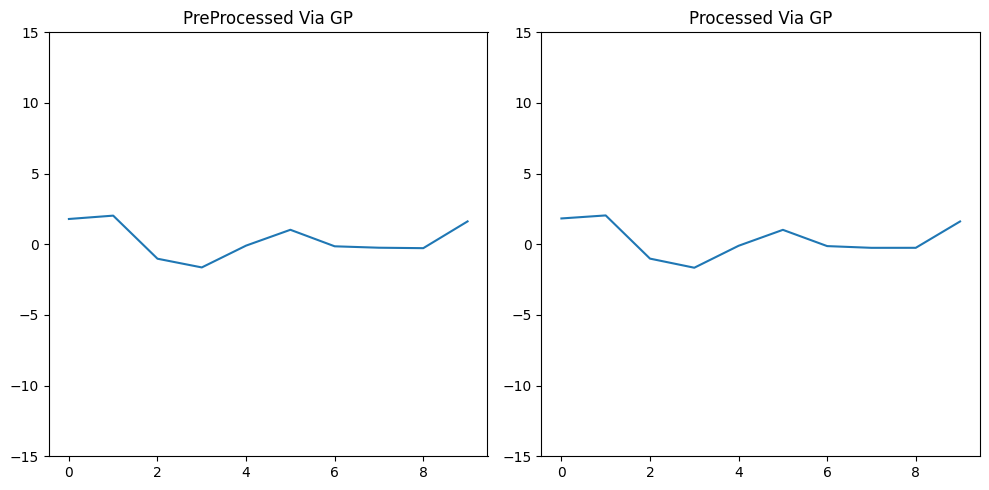

In [46]:
import matplotlib.pyplot as plt
# Distance matrix 
L = jnp.arange(1,11)
m = jnp.abs(L[:, None] - L[None, :])

# Kernel
@jit
def sq_exp_kernel(m, sq_alpha=0.5, sq_rho=0.1, delta=0):
    """Squared Exponential Kernel.

    The SE kernel is a widely used kernel in Gaussian processes (GPs) and support vector machines (SVMs). It has some desirable properties, such as universality and infinite differentiability. This function computes the covariance matrix using the squared exponential kernel.

    Args:
        m (array): Input array representing the distances between data points.
        sq_alpha (float, optional): Scale parameter of the squared exponential kernel. Defaults to 0.5.
        sq_rho (float, optional): Length-scale parameter of the squared exponential kernel. Defaults to 0.1.
        delta (int, optional): Delta value to be added to the diagonal of the covariance matrix. Defaults to 0.

    Returns:
        tuple: A tuple containing:
            - K (array): The covariance matrix computed using the squared exponential kernel.
            - cov (array): A masked covariance matrix with the upper triangular part set to zero.
    """
    # Get the number of data points
    N = m.shape[0]
    
    # Compute the kernel matrix using the squared exponential kernel
    K = sq_alpha * jnp.exp(-sq_rho *  jnp.square(m))
    
    # Set the diagonal elements of the kernel matrix
    K = K.at[jnp.diag_indices(N)].set(sq_alpha + delta)
    
    # Create a mask for the upper triangular part of the covariance matrix
    mask = jnp.triu(jnp.ones_like(K, dtype=bool))
    
    # Apply the mask to set the upper triangular part of the covariance matrix to zero
    cov = jnp.where(mask, K, 0)
    
    return K, cov


r = sq_exp_kernel(m, 1, 4)
Z = Normal(0,1).sample(10, seed = init_key)
a = r[1] @ jnp.transpose(r[1]) @ Z


# Set up subplots
plt.figure(figsize=(10, 5))
# Plot the first subplot
plt.subplot(1, 2, 1)
plt.plot(Z)
plt.title("PreProcessed Via GP")
plt.ylim(-15, 15)


# Plot the second subplot
plt.subplot(1, 2, 2)
plt.plot(a)
plt.title("Processed Via GP")
plt.ylim(-15, 15)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [62]:
@jit
def periodic_kernel(m, sigma=1, length_scale=1.0, period=1.0):
    """Periodic Kernel.

    The periodic kernel is often used in Gaussian processes (GPs) for modeling functions with periodic behavior.

    Args:
        m (array): Input array representing the absolute distances between data points.
        sigma (float, optional): Scale parameter of the kernel. Defaults to 1.0.
        length_scale (float, optional): Length scale parameter of the kernel. Defaults to 1.0.
        period (float, optional): Period parameter of the kernel. Defaults to 1.0.

    Returns:
        array: The covariance matrix computed using the periodic kernel.
    """    
    # Compute the kernel matrix using the squared exponential kernel
    return sigma**2 * jnp.exp(-2*jnp.sin(jnp.pi * m / period)**2 / length_scale**2) 



In [63]:
@jit
def local_periodic_kernel(m, sigma=1, length_scale=1.0, period=1.0):
    """Locally Periodic Kernel

    A SE kernel times a periodic results in functions which are periodic, but which can slowly vary over time.

    Args:
        m (array): Input array representing the absolute distances between data points.
        sigma (float, optional): Scale parameter of the kernel. Defaults to 1.0.
        length_scale (float, optional): Length scale parameter of the kernel. Defaults to 1.0.
        period (float, optional): Period parameter of the kernel. Defaults to 1.0.

    Returns:
        array: The covariance matrix computed using the periodic kernel.
    """    
    # Compute the kernel matrix using the squared exponential kernel
    return sigma**2 * jnp.exp(-2*jnp.sin(jnp.pi * m / period)**2 / length_scale**2)  * jnp.exp(-(m**2/ 2*length_scale**2))

# Learnable Distributions

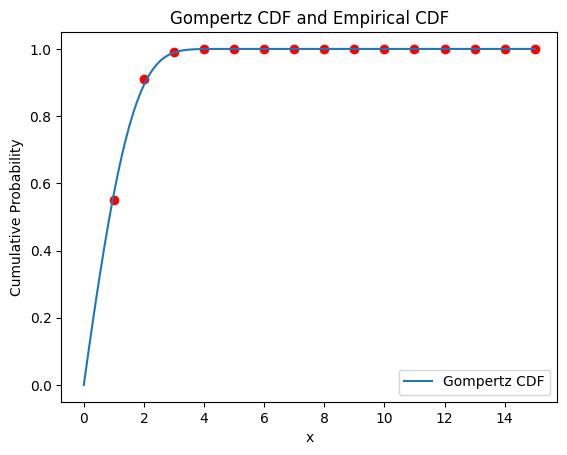

In [86]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

def dgompertz(x, eta, b):
    """This function calculates the probability density function (PDF) of the Gompertz distribution.

    Args:
        x (_type_): _description_
        eta (_type_): _description_
        b (_type_): _description_

    Returns:
        _type_: _description_
    """
    return b * eta * jnp.exp(eta + b * x - eta * jnp.exp(b * x))

def cgompertz(x, eta, b):
    """This function calculates the cumulative distribution function (CDF) of the Gompertz distribution.

    Args:
        x (_type_): _description_
        eta (_type_): _description_
        b (_type_): _description_

    Returns:
        _type_: _description_
    """
    return 1 - jnp.exp(-eta * (jnp.exp(b * x) - 1))

def qgompertz(p, eta, b):
    """This function calculates the quantile function (inverse CDF) of the Gompertz distribution.

    Args:
        p (_type_): _description_
        eta (_type_): _description_
        b (_type_): _description_

    Returns:
        _type_: _description_
    """
    return jnp.log(-jnp.log(1 - p) / eta + 1) / b

def rgompertz(key, n, eta, b):
    """This function generates random samples from the Gompertz distribution.

    Args:
        key (_type_): _description_
        n (_type_): _description_
        eta (_type_): _description_
        b (_type_): _description_

    Returns:
        _type_: _description_
    """
    u = random.uniform(key, shape=(n,))
    return jnp.log(-jnp.log(1 - u) / eta + 1) / b

# Example usage:
key = random.PRNGKey(0)  # Random key for reproducibility
eta = 1.3
b = 0.5
n = 100

x = rgompertz(key, n, eta, b)

# Plot the CDF of the Gompertz distribution
x_values = jnp.linspace(0, 15, 400)
y_values = cgompertz(x_values, eta, b)
plt.plot(x_values, y_values, label='Gompertz CDF')

# Add points representing the empirical CDF based on the generated samples
for i in range(1, 16):
    empirical_cdf = jnp.mean(x <= i)
    plt.scatter(i, empirical_cdf, color='red')

# Display the plot
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.title('Gompertz CDF and Empirical CDF')
plt.legend()
plt.show()

# Create a dictionary with the length of x and x itself
dl = {'n': len(x), 'x': x}

In [ ]:
def rgompertz(key, n, eta, b):
    u = random.uniform(key, shape=(n,))
    return jnp.log(-jnp.log(1 - u) / eta + 1) / b

def model():
    eta  = yield lognormal(1,0,1)
    b = yield lognormal(1,0,1)
    tmp = rgompertz(key, n, eta, b)
    print(tmp.shape)
    y = yield Independent(Normal(tmp, 1), reinterpreted_batch_ndims=1)

def target_log_prob(*params):
    eta, b = params
    return jnp.log(b) + jnp.log(eta) + eta + b * x - eta * jnp.exp(b * x)   

init_key, key = random.split(random.PRNGKey(int(0)))
init_key = jnp.array(init_key)
tensor = JointDistributionCoroutine(model)
infos = get_distributions(model)
init_params = tensor.sample(seed = init_key)
init_params = list(init_params)[:-1]
_, bijectors = initialise(infos, init_params)

names = infos.keys()
def trace_fn(_, pkr):
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
    )

@jit
def run_chain(key):
    inner_kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob,
        step_size= 1e-3
    )
    kernel = tensorflow_probability.substrates.jax.mcmc.TransformedTransitionKernel(
            inner_kernel=inner_kernel,
            bijector=bijectors
    )
    
    hmc  = tfp.mcmc.DualAveragingStepSizeAdaptation(
        kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*500),
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
              inner_results=pkr.inner_results._replace(step_size=new_step_size)
          ),
        step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    )
    
    return tfp.mcmc.sample_chain(num_results = 500,
                                 num_steps_between_results = 0,
                                 current_state= init_params,
                                 kernel=hmc,
                                 trace_fn=trace_fn,
                                 num_burnin_steps=0.8,
                                 parallel_iterations = 10,
                                 seed=key)

start = tm.time()  
rng_keys = jax.random.split(random.PRNGKey(0), 1)
result =  jax.pmap(run_chain)(rng_keys)
end = tm.time()    
print(f"HonnorMode took: {end - start:.4f} seconds")
posterior, sample_stats = result
posterior

In [ ]:

posterior, sample_stats = NUTStrans(model, obs =  x, target_log_prob_fn= logProb)
posterior

In [25]:
import tensorflow.compat.v2 as tf
from tensorflow_probability.python.bijectors import sigmoid as sigmoid_bijector
from tensorflow_probability.python.distributions import distribution
from tensorflow_probability.python.distributions import kullback_leibler
from tensorflow_probability.python.internal import assert_util
from tensorflow_probability.python.internal import distribution_util
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import parameter_properties
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import reparameterization
from tensorflow_probability.python.internal import samplers
from tensorflow_probability.python.internal import tensor_util


class Gompertz(
    distribution.DiscreteDistributionMixin,
    distribution.AutoCompositeTensorDistribution):

  def __init__(self,
               eta=None,
               b=None,
               dtype=tf.float32,
               validate_args=False,
               allow_nan_stats=True,
               name='Gompertz'):
    parameters = dict(locals())

    with tf.name_scope(name) as name:
      self.eta = tensor_util.convert_nonref_to_tensor(
          eta, dtype_hint=tf.float32, name='probs')
      self.b = tensor_util.convert_nonref_to_tensor(
          b, dtype_hint=tf.float32, name='logits')
    super(Gompertz, self).__init__(
        dtype=dtype,
        reparameterization_type=reparameterization.NOT_REPARAMETERIZED,
        validate_args=validate_args,
        allow_nan_stats=allow_nan_stats,
        parameters=parameters,
        name=name)

  @classmethod
  def _parameter_properties(cls, dtype, num_classes=None):
    return dict(
        eta=parameter_properties.ParameterProperties(),
        b=parameter_properties.ParameterProperties()

  @property
  def eta(self):
    """Input argument `eta`."""
    return self.eta

  @property
  def b(self):
    """Input argument `b`."""
    return self.b

  def _event_shape_tensor(self):
    return tf.constant([], dtype=tf.float32)

  def _event_shape(self):
    return tf.TensorShape([])

  def _sample_n(self, n, seed=None):
    probs = self._probs_parameter_no_checks()
    new_shape = ps.concat([[n], ps.shape(probs)], 0)
    uniform = samplers.uniform(new_shape, seed=seed, dtype=probs.dtype)
    sample = tf.less(uniform, probs)
    return tf.cast(sample, self.dtype)

  def _log_prob(self, event):
    log_probs0, log_probs1 = self._outcome_log_probs()
    event = tf.cast(event, log_probs0.dtype)
    return (tf.math.multiply_no_nan(log_probs0, 1 - event) +
            tf.math.multiply_no_nan(log_probs1, event))

  def _outcome_log_probs(self):

    return -tf.math.softplus(s), -tf.math.softplus(-s)

  def _cdf(self, event):
    prob = self._probs_parameter_no_checks()
    return tf.where(event < 0, 0.0, tf.where(event < 1, 1.0 - prob, 1.0))

  def _entropy(self):
    probs0, probs1, log_probs0, log_probs1 = _probs_and_log_probs(
        probs=self._probs, logits=self._logits, return_log_probs=True)
    return -1. * (
        tf.math.multiply_no_nan(log_probs0, probs0) +
        tf.math.multiply_no_nan(log_probs1, probs1))

  def _mean(self):
    return self._probs_parameter_no_checks()

  def _variance(self):
    probs0, probs1 = _probs_and_log_probs(
        probs=self._probs, logits=self._logits, return_log_probs=False)
    return probs0 * probs1

  def _mode(self):
    """Returns `1` if `prob > 0.5` and `0` otherwise."""
    return tf.cast(self._probs_parameter_no_checks() > 0.5, self.dtype)

  def logits_parameter(self, name=None):
    """Logits computed from non-`None` input arg (`probs` or `logits`)."""
    with self._name_and_control_scope(name or 'logits_parameter'):
      return self._logits_parameter_no_checks()

  def _logits_parameter_no_checks(self):
    if self._logits is None:
      probs = tf.convert_to_tensor(self._probs)
      return tf.math.log(probs) - tf.math.log1p(-probs)
    return tensor_util.identity_as_tensor(self._logits)

  def probs_parameter(self, name=None):
    """Probs computed from non-`None` input arg (`probs` or `logits`)."""
    with self._name_and_control_scope(name or 'probs_parameter'):
      return self._probs_parameter_no_checks()

  def _probs_parameter_no_checks(self):
    if self._logits is None:
      return tensor_util.identity_as_tensor(self._probs)
    return tf.math.sigmoid(self._logits)

  def _default_event_space_bijector(self):
    return

  @classmethod
  def _maximum_likelihood_parameters(cls, value):
    return {'probs': tf.reduce_mean(value, axis=0)}

  def _parameter_control_dependencies(self, is_init):
    return maybe_assert_bernoulli_param_correctness(is_init, self.validate_args, self._probs, self._logits)

  def _sample_control_dependencies(self, x):
    assertions = []
    if not self.validate_args:
      return assertions
    assertions.extend(distribution_util.assert_nonnegative_integer_form(x))
    assertions.append(
        assert_util.assert_less_equal(
            x, tf.ones([], dtype=x.dtype),
            message='Sample must be less than or equal to `1`.'))
    return assertions
  

SyntaxError: '(' was never closed (2121884511.py, line 43)

In [24]:
Gompertz(1).sample(20)

NameError: name 'Gompertz' is not defined

In [214]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

class Gompertz(tfd.Distribution):
    def __init__(self, eta, b, validate_args=False, allow_nan_stats=True, name="Gompertz"):
        parameters = dict(locals())
        with tf.name_scope(name) as name:
            self.eta = tf.convert_to_tensor(eta, dtype=tf.float32, name="eta")
            self.b = tf.convert_to_tensor(b, dtype=tf.float32, name="b")
            super(Gompertz, self).__init__(
                dtype=self.eta.dtype,
                reparameterization_type=tfd.FULLY_REPARAMETERIZED,
                validate_args=validate_args,
                allow_nan_stats=allow_nan_stats,
                parameters=parameters,
                name=name)

    def _batch_shape_tensor(self):
        return tf.broadcast_dynamic_shape(tf.shape(self.eta), tf.shape(self.b))

    def _batch_shape(self):
        return tf.broadcast_static_shape(self.eta.shape, self.b.shape)

    def _event_shape_tensor(self):
        return tf.constant([], dtype=tf.int32)

    def _event_shape(self):
        return tf.TensorShape([])

    def _log_prob(self, x):
        eta = self.eta
        b = self.b
        return tf.math.log(b) + tf.math.log(eta) + eta + b * x - eta * tf.math.exp(b * x)

    def _cdf(self, x):
        eta = self.eta
        b = self.b
        return 1. - tf.math.exp(-eta * (tf.math.exp(b * x) - 1.))

    def _sample_n(self, n, seed=None):
        eta = self.eta
        b = self.b
        u = tf.random.uniform(shape=[n], seed=seed, dtype=self.dtype)
        return tf.math.log(-tf.math.log(1. - u) / eta + 1.) / b

# Define learnable parameters
eta = tf.Variable(1.3, dtype=tf.float32, name='eta')
b = tf.Variable(0.5, dtype=tf.float32, name='b')

# Create an instance of the Gompertz distribution with learnable parameters
gompertz_dist = Gompertz(eta=eta, b=b)

# Example: computing the log probability of a sample
sample = tf.constant([0.5, 1.0, 1.5], dtype=tf.float32)
log_prob = gompertz_dist.log_prob(sample)
print("Log probability of sample:", log_prob.numpy())

# Example: drawing samples from the distribution
samples = gompertz_dist.sample(1000)
print("Samples:", samples.numpy())

# Example: fitting the distribution to data
data = samples  # In practice, you would use your dataset here
optimizer = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        nll = -tf.reduce_mean(gompertz_dist.log_prob(data))  # Negative log likelihood
    gradients = tape.gradient(nll, [eta, b])
    optimizer.apply_gradients(zip(gradients, [eta, b]))
    return nll

# Training loop
for step in range(1000):
    nll = train_step()
    if step % 100 == 0:
        print(f"Step {step}: NLL = {nll.numpy()}, eta = {eta.numpy()}, b = {b.numpy()}")

print(f"Fitted eta: {eta.numpy()}, Fitted b: {b.numpy()}")


Log probability of sample: [-0.5500158  -0.77412045 -1.132883  ]
Samples: [2.28469634e+00 2.33874202e+00 1.87490487e+00 2.41405869e+00
 1.39808154e+00 4.43970442e-01 7.01626301e-01 5.32675162e-02
 4.98693138e-01 2.58231688e+00 1.25846529e+00 9.91220355e-01
 1.12735081e+00 9.59754407e-01 2.11598545e-01 2.73563838e+00
 1.04305756e+00 2.71856976e+00 2.38767847e-01 1.35787833e+00
 6.37294590e-01 1.06195137e-01 1.73686653e-01 1.51281029e-01
 8.44262540e-01 2.18797612e+00 2.19362402e+00 8.11356783e-01
 2.25915432e+00 1.79151487e+00 9.84604597e-01 4.83774036e-01
 1.02526411e-01 1.20222557e+00 1.17362328e-01 1.03268266e+00
 3.29465294e+00 9.54857826e-01 1.25356066e+00 7.08465874e-01
 7.78900445e-01 1.47081865e-02 4.09788758e-01 8.94750893e-01
 9.56156015e-01 1.45893216e-01 1.82427382e+00 3.17324996e-01
 1.44575536e-01 1.94167301e-01 1.44673383e+00 1.12765384e+00
 1.27260220e+00 8.57538730e-03 3.76007468e-01 1.42078650e+00
 5.81966519e-01 1.09778738e+00 1.17388129e+00 1.16678071e+00
 6.32805586

ValueError: in user code:

    File "/tmp/ipykernel_30880/518415903.py", line 73, in train_step  *
        optimizer.apply_gradients(zip(gradients, [eta, b]))
    File "/home/sosa/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "/home/sosa/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 335, in apply
        grads, trainable_variables = self._filter_empty_gradients(
    File "/home/sosa/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 662, in _filter_empty_gradients
        raise ValueError("No gradients provided for any variable.")

    ValueError: No gradients provided for any variable.
